In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler
from tqdm import tqdm
#import random
import warnings
warnings.filterwarnings('ignore')


from ode_filters.sqr_gaussian_inference import * 
from ode_filters.gaussian_inference import *
from ode_filters.ODE_filters import *



### Plotting Specifications

In [2]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [3]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [4]:
from tueplots import figsizes
#figsize_config = figsizes.neurips2024(nrows=1, ncols=1)
figsize_config = figsizes.aaai2024_half(nrows=2, ncols=1)
##figsize_config['figure.figsize'][1] = 0.5
plt.rcParams.update(figsize_config)
print(plt.rcParams['figure.figsize'])

[3.3, 4.079024325749306]


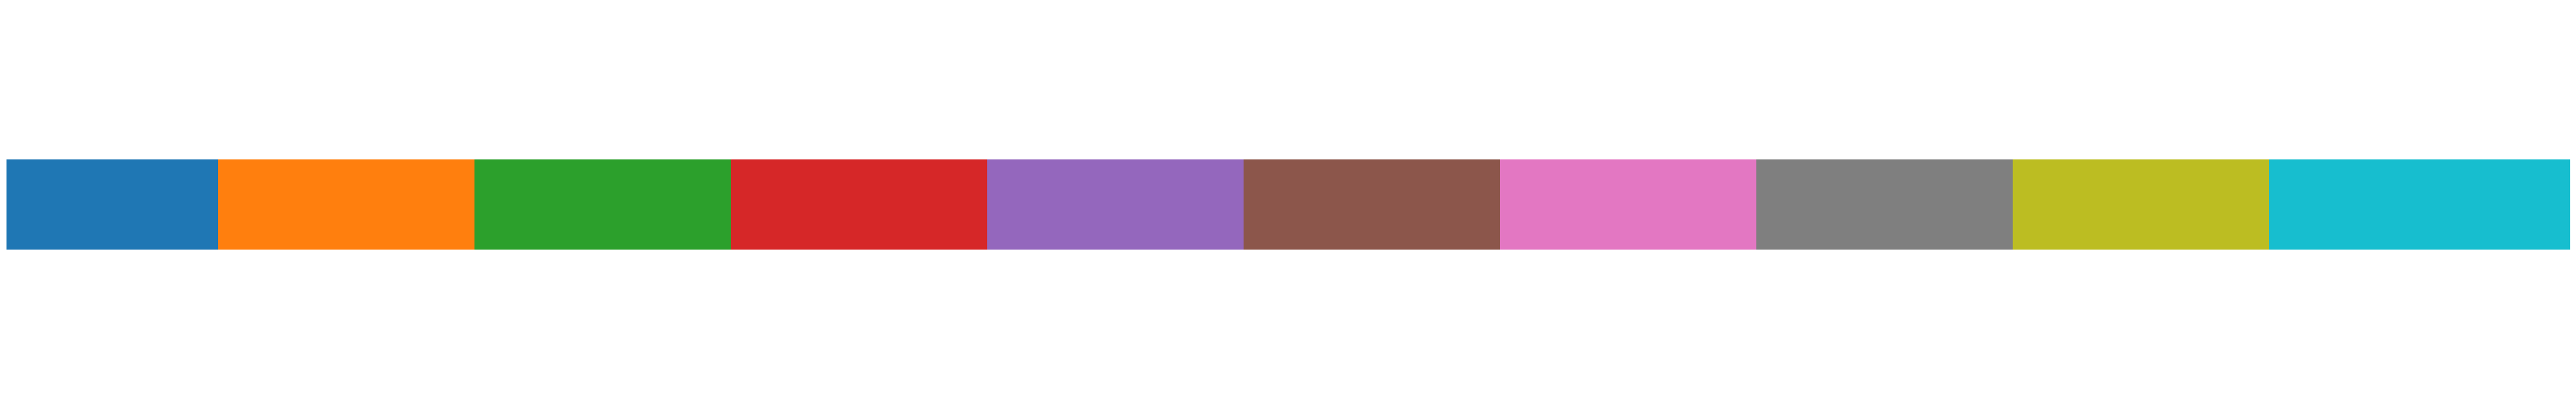

In [5]:
# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### ODE Problem Setup

In [6]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
q = 3
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 0.5
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 21
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[2*X[0] - 1, 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

### Compute and Plot filtering results

In [8]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [10]:
m_sequence, P_sequence, m_predictions, P_predictions, Gs, ds, Lambdas = compute_kalman_forward_with_backward_transitions(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

### Plotting Helpers

In [11]:
def plot_ax(ts, m, P, t, x_exact, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts, m, color=colors[5], marker='.', label="filtered estimate")
    #ax.scatter(ts, m, color=colors[5], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    ax.fill_between(ts, m - margin, m + margin, alpha=0.2, color=colors[5], label=r'$\pm 1\sigma$')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [12]:
def plot_ax_with_pred(ts, m, P, t, x_exact, m_future, P_future, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k+1], m[:k+1], color=colors[5], marker='.', label="filtered estimate",zorder=8)
    ax.plot(ts[k:], m_future, color='black', label="future prediction", alpha=0.6)
    #ax.scatter(ts, m, color=colors[5], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    margin_future = 2*np.sqrt(P_future)
    ax.fill_between(ts[:k+1], m[:k+1] - margin[:k+1], m[:k+1] + margin[:k+1], alpha=0.2, color=colors[5]) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k:], m_future - margin_future, m_future + margin_future, alpha=0.1, color='black')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [13]:
def plot_ax_with_smooth(ts, m, P, t, x_exact, m_smoothed, P_smoothed, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color=colors[5], marker='.', label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_smoothed[k-1:], color=colors[6], marker='*', label="smoothed estimate", zorder=9)
    #ax.scatter(ts, m, color=colors[5], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    margin_smoothed = 2*np.sqrt(P_smoothed)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color=colors[5]) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_smoothed[k-1:] - margin_smoothed[k-1:], m_smoothed[k-1:] + margin_smoothed[k-1:], alpha=0.2, color=colors[6])#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [14]:
zs = m_sequence[:,1] - m_sequence[:,0]*(1 - m_sequence[:,0])
# Uncertainty via linearization
zf_var = []
for k in range(m_sequence.shape[0]):
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)
zf_var = np.maximum(np.array(zf_var).reshape(-1), 0)

### Iterative Forward plotting

In [15]:
def create_forward_plot(k, savefig=False):
    m_future, P_future = predict_future(k, m_sequence[k], P_sequence[k,...], A_h, Q_h, N)
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])


    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    plot_ax_with_pred(ts, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:k], z_sequence[:k-1], label="observed data", marker='x', color=colors[0], zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

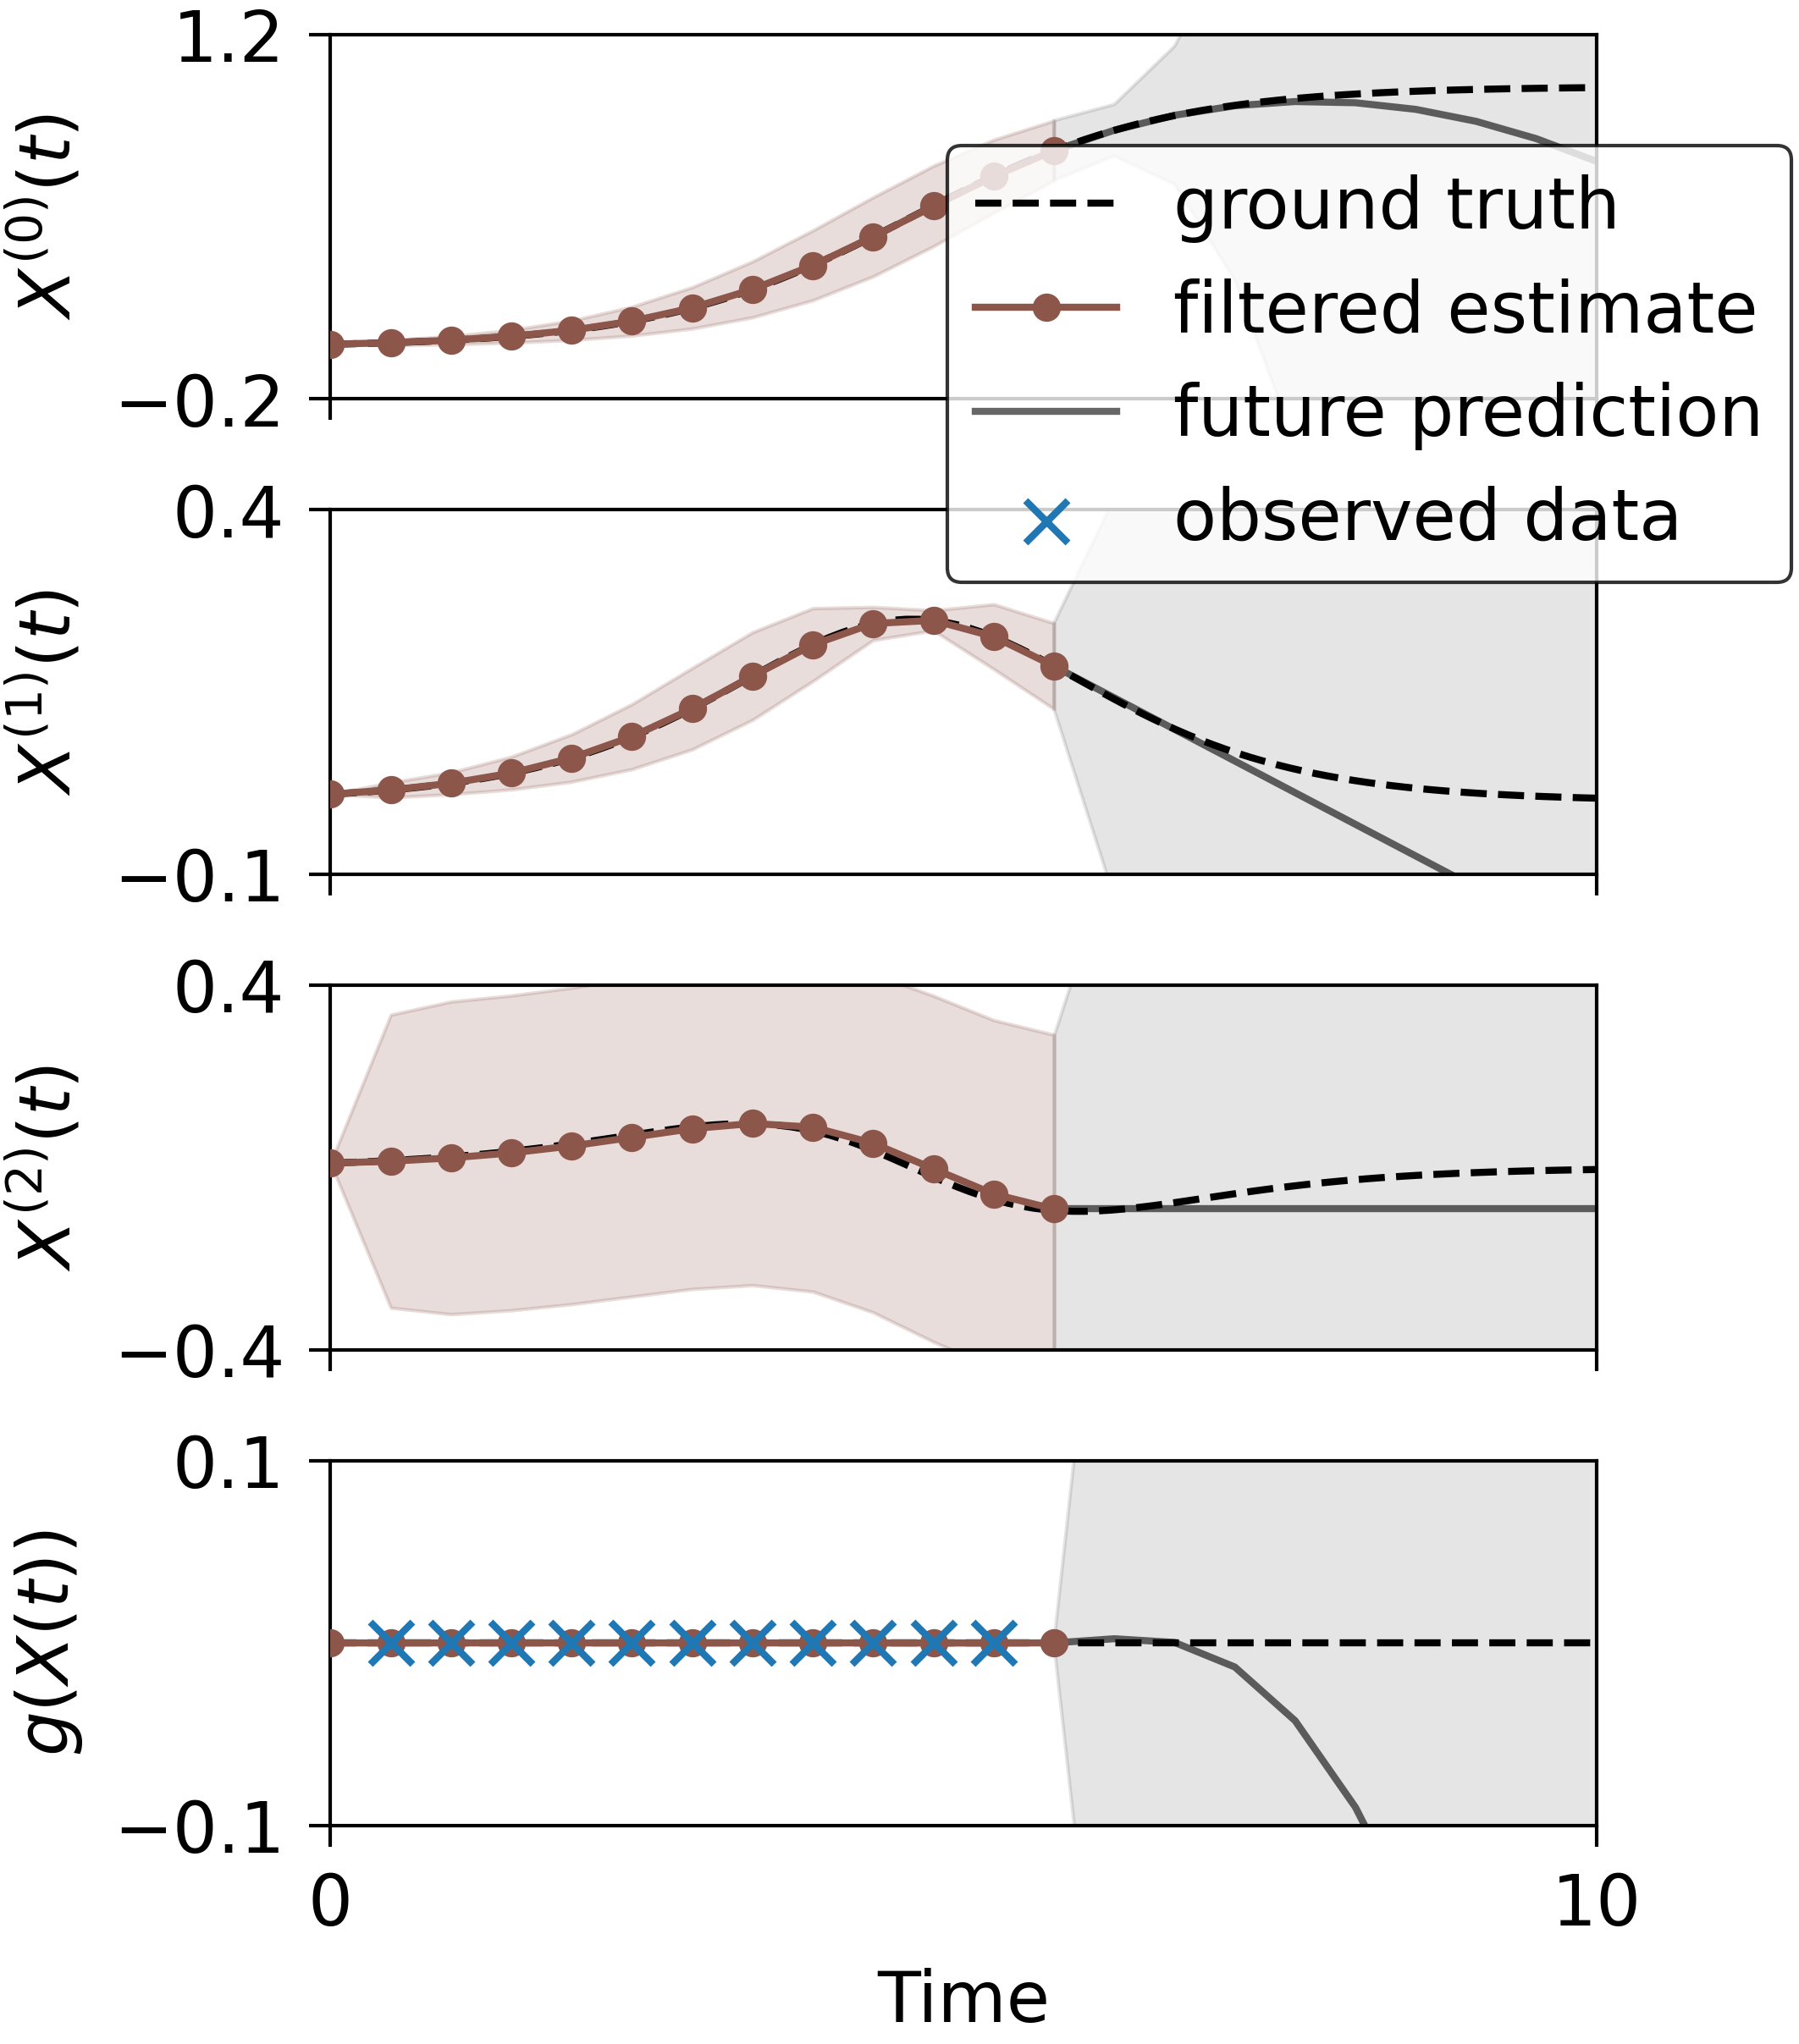

In [16]:
create_forward_plot(12)

In [ ]:
for i in range(1,N+1):
    create_forward_plot(i, savefig=True)

In [ ]:
#function that samples q-times IWP path from initialiyation x_0
def sample_IWP_path_forward(q, N, h, x_k):

    x = np.zeros((N, q))
    x[0,:] = x_k

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x

In [ ]:
def sample_backward_transitions(q, N, h, x_k, Gs, ds, Lambdas):
    x_sample = np.zeros((N,q))
    x_sample[-1,:] = x_k
    for i in range(1,N):
        x_sample[-(i+1),:] = np.random.multivariate_normal(Gs[-i] @ x_sample[-i,:] + ds[-i], Lambdas[-i])
    return x_sample

In [ ]:
k = 13
#sample at current position
x_k = np.random.multivariate_normal(m_sequence[k,:], P_sequence[k,...])
#sample forward path from IWP
x_forw = [sample_IWP_path_forward(q, N-k+1, h, x_k) for _ in range(5)]
#sample backward path from backward transitions
x_backw = sample_backward_transitions(q, k+1, h, x_k, Gs[:k,...], ds[:k,...], Lambdas[:k,...])

In [ ]:
def create_forward_plot_with_samples(k, h, ts, savefig=False, num_samples=5):
    m_future, P_future = predict_future(k, m_sequence[k], P_sequence[k,...], A_h, Q_h, N)
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    #sample at current position
    x_k = [np.random.multivariate_normal(m_sequence[k,:], P_sequence[k,...]) for _ in range(num_samples)]
    #sample forward path from IWP
    x_forw = [sample_IWP_path_forward(q, N+1-k, h, x_k[j]) for j in range(num_samples)]
    #sample backward path from backward transitions
    x_backw = [sample_backward_transitions(q, k+1, h, x_k[j], Gs[:k+1,...], ds[:k+1,...], Lambdas[:k+1,...]) for j in range(num_samples)]
    x_forw = np.moveaxis(np.array(x_forw), 0, -1)
    x_backw = np.moveaxis(np.array(x_backw), 0, -1)

    print(x_forw.shape)
    print(x_backw.shape)
    
    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(True)  # Enable gridlines
        
        #add sample plots
        axs[i].plot(ts[:k+1], x_backw[:,i], color=colors[5], alpha=0.3)
        axs[i].plot(ts[k:], x_forw[:,i], color='black', alpha=0.3)

    axs[3].plot(ts[:k+1], x_backw[:,1]-x_backw[:,0]*(1-x_backw[:,0]), color=colors[5], alpha=0.3)
    axs[3].plot(ts[k:], x_forw[:,1]-x_forw[:,0]*(1-x_forw[:,0]), color='black', alpha=0.3)

    plot_ax_with_pred(ts, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:k+1], z_sequence[:k], label="observed data", marker='x', color=colors[0], zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')
    axs[-1].set_xticks(ts)
    axs[-1].grid(True)  # Enable gridlines for the last plot

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

(10, 3, 5)
(13, 3, 5)


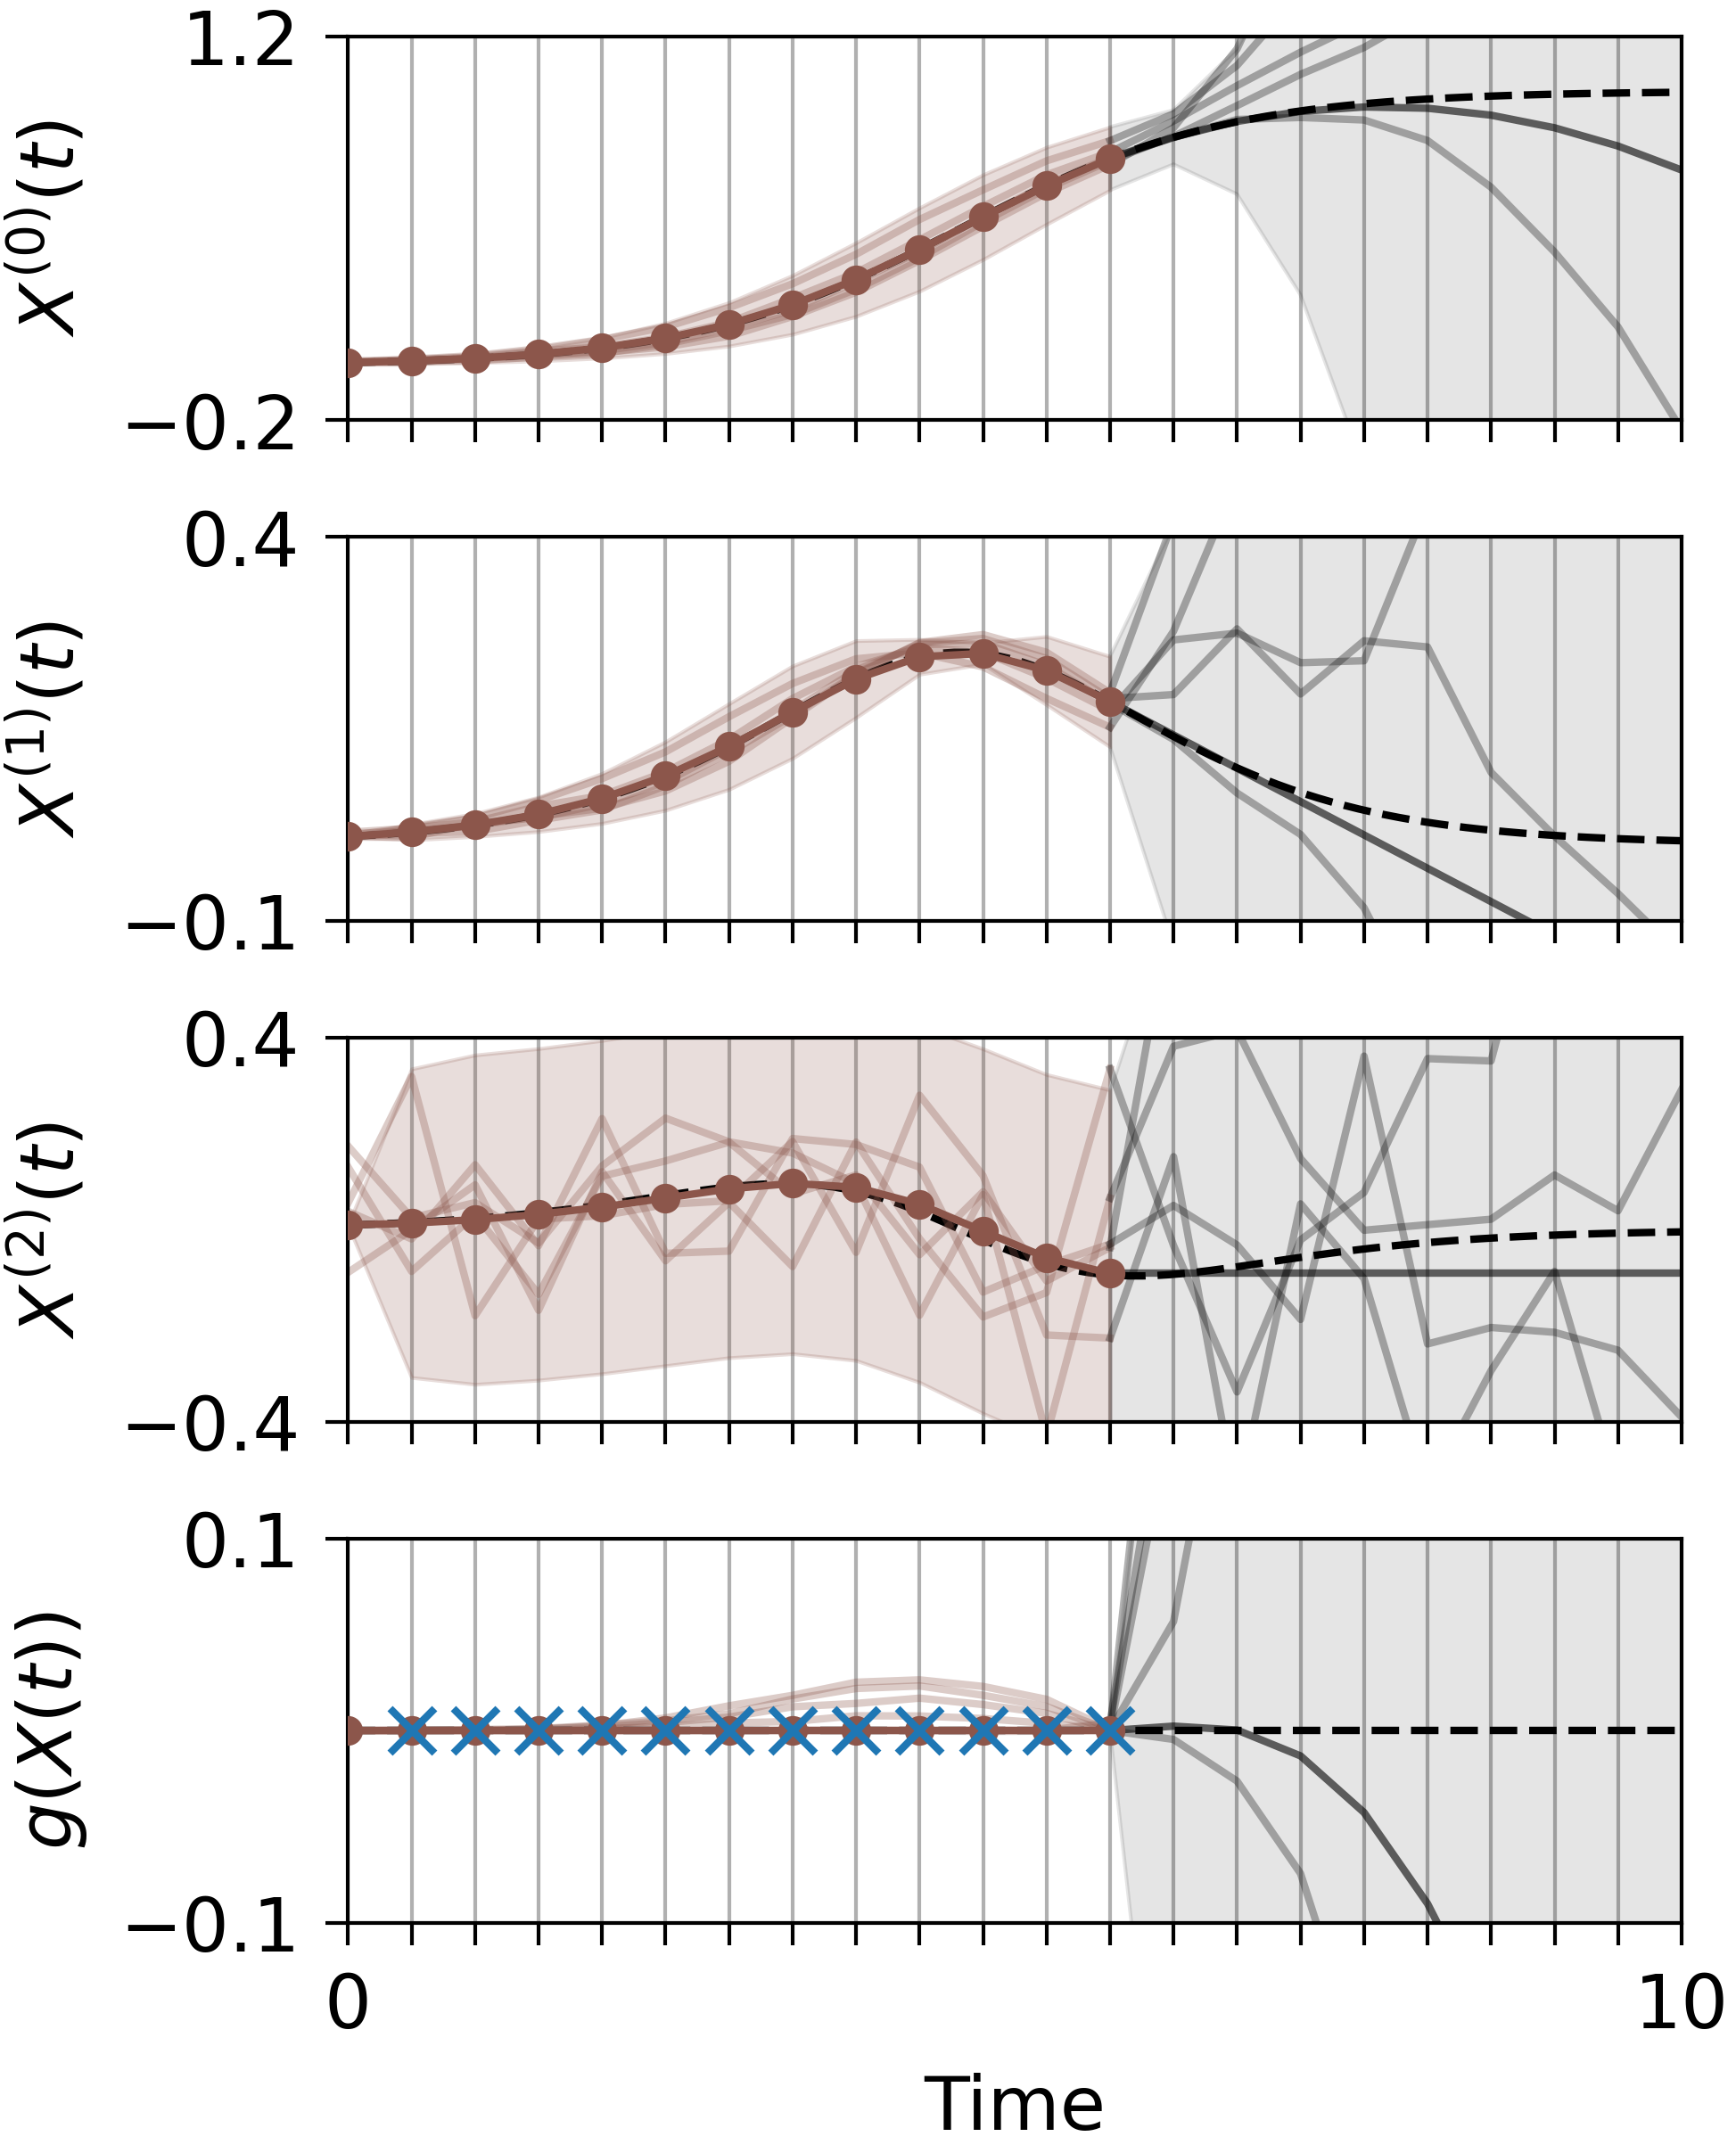

In [ ]:
create_forward_plot_with_samples(12, h, ts, num_samples=5)

#### Add intermediate points without observations!

In [ ]:
#Discretization
t0, t1 = 0.0, 10.0
N = 20
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N

# number of intermediate points 
I = 10
M = I*N
ts2 = np.linspace(t0,t1, M+1, endpoint=True)
h2 = (t1 - t0)/M

#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Consequences of constant step size
A_h2 = A(h2)
Q_h2 = Q(h2)

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[2*X[0] - 1, 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ] [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.85  3.9   3.95  4.    4.05  4.1   4.15
  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35
  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95
  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.

In [ ]:
m_sequence, P_sequence, m_predictions, P_predictions, Gs, ds, Lambdas = compute_kalman_forward_with_backward_transitions_intermediate(mu_0, Sigma_0, A_h2, b_h, Q_h2, R_h, g, jacobian_g, z_sequence, N, M)

In [ ]:
zs = m_sequence[:,1] - m_sequence[:,0]*(1 - m_sequence[:,0])
# Uncertainty via linearization
zf_var = []
for k in range(m_sequence.shape[0]):
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)
zf_var = np.maximum(np.array(zf_var).reshape(-1), 0)

In [ ]:
def plot_ax_with_pred2(ts, m, P, t, x_exact, m_future, P_future, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k+1], m[:k+1], color=colors[5], label="filtered estimate",zorder=8, alpha=0.8, linewidth=2)
    ax.plot(ts[k:], m_future, color='black', label="future prediction", alpha=0.6, linewidth=2)
    #ax.scatter(ts, m, color=colors[5], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    margin_future = 2*np.sqrt(P_future)
    ax.fill_between(ts[:k+1], m[:k+1] - margin[:k+1], m[:k+1] + margin[:k+1], alpha=0.2, color=colors[5]) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k:], m_future - margin_future, m_future + margin_future, alpha=0.1, color='black')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [ ]:
def create_forward_plot_with_intermediate_samples(k, h, ts, ts2, N, M, savefig=False, num_samples=5):
    m_future, P_future = predict_future(k, m_sequence[k,:], P_sequence[k,...], A_h2, Q_h2, M)
    #m_future, P_future = m_predictions[k:,:], P_predictions[k:,...]
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    #sample at current position
    x_k = [np.random.multivariate_normal(m_sequence[k,:], P_sequence[k,...]) for _ in range(num_samples)]
    #sample forward path from IWP
    x_forw = [sample_IWP_path_forward(q, M+1-k, h, x_k[j]) for j in range(num_samples)]
    #sample backward path from backward transitions
    x_backw = [sample_backward_transitions(q, k+1, h, x_k[j], Gs[:k+1,...], ds[:k+1,...], Lambdas[:k+1,...]) for j in range(num_samples)]
    x_forw = np.moveaxis(np.array(x_forw), 0, -1)
    x_backw = np.moveaxis(np.array(x_backw), 0, -1)
    
    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred2(ts2, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred2(ts2, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred2(ts2, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(True)  # Enable gridlines
        
        #add sample plots
        axs[i].plot(ts2[:k+1], x_backw[:,i], color=colors[5], alpha=0.3)
        axs[i].plot(ts2[k:], x_forw[:,i], color='black', alpha=0.3)

    axs[3].plot(ts2[:k+1], x_backw[:,1]-x_backw[:,0]*(1-x_backw[:,0]), color=colors[5], alpha=0.3)
    axs[3].plot(ts2[k:], x_forw[:,1]-x_forw[:,0]*(1-x_forw[:,0]), color='black', alpha=0.3)

    plot_ax_with_pred2(ts2, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    I = M//N
    l = k//I
    axs[-1].scatter(ts[1:l+1], z_sequence[:l], label="observed data", marker='.', color=colors[0], zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    axs[-1].set_ylabel('$g(X(t))$')
    axs[-1].set_xticks(ts)
    axs[-1].grid(True)  # Enable gridlines for the last plot

    # Build a figure-level legend from all axes
    #handles, labels = [], []
    #for ax in axs:
    #    he, l = ax.get_legend_handles_labels()
    #    handles.extend(he)
    #    labels.extend(l)
    #by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
def create_forward_plot_with_intermediate(k, h, ts, ts2, N, M, savefig=False):
    m_future, P_future = predict_future(k, m_sequence[k,:], P_sequence[k,...], A_h2, Q_h2, M)
    #m_future, P_future = m_predictions[k:,:], P_predictions[k:,...]
    zs_future = m_future[:,1] - m_future[:,0]*(1 - m_future[:,0])
    # Uncertainty via linearization
    zf_var_future = []
    for m in range(m_future.shape[0]):
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.maximum(np.array(zf_var_future).reshape(-1), 0)

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_pred2(ts2, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_future[:,0], P_future[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_pred2(ts2, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_future[:,1], P_future[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_pred2(ts2, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_future[:,2], P_future[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        #axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(True)  # Enable gridlines

    axs[0].set_ylabel(r'$x(t)$')
    axs[1].set_ylabel(r'$\dot{x}(t)$')
    axs[2].set_ylabel(r'$\ddot{x}(t)$')
    axs[3].set_ylabel('residual')

    plot_ax_with_pred2(ts2, zs, zf_var, t, np.zeros_like, zs_future, zf_var_future, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    I = M//N
    l = k//I
    axs[-1].scatter(ts[1:l+1], z_sequence[:l], label="observed data", marker='.', color=colors[0], zorder=10)
    
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    #axs[-1].set_ylabel('$g(X(t))$')
    axs[-1].set_xticks(ts)
    axs[-1].grid(True)  # Enable gridlines for the last plot

    # Build a figure-level legend from all axes
    #handles, labels = [], []
    #for ax in axs:
    #    he, l = ax.get_legend_handles_labels()
    #    handles.extend(he)
    #    labels.extend(l)
    #by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

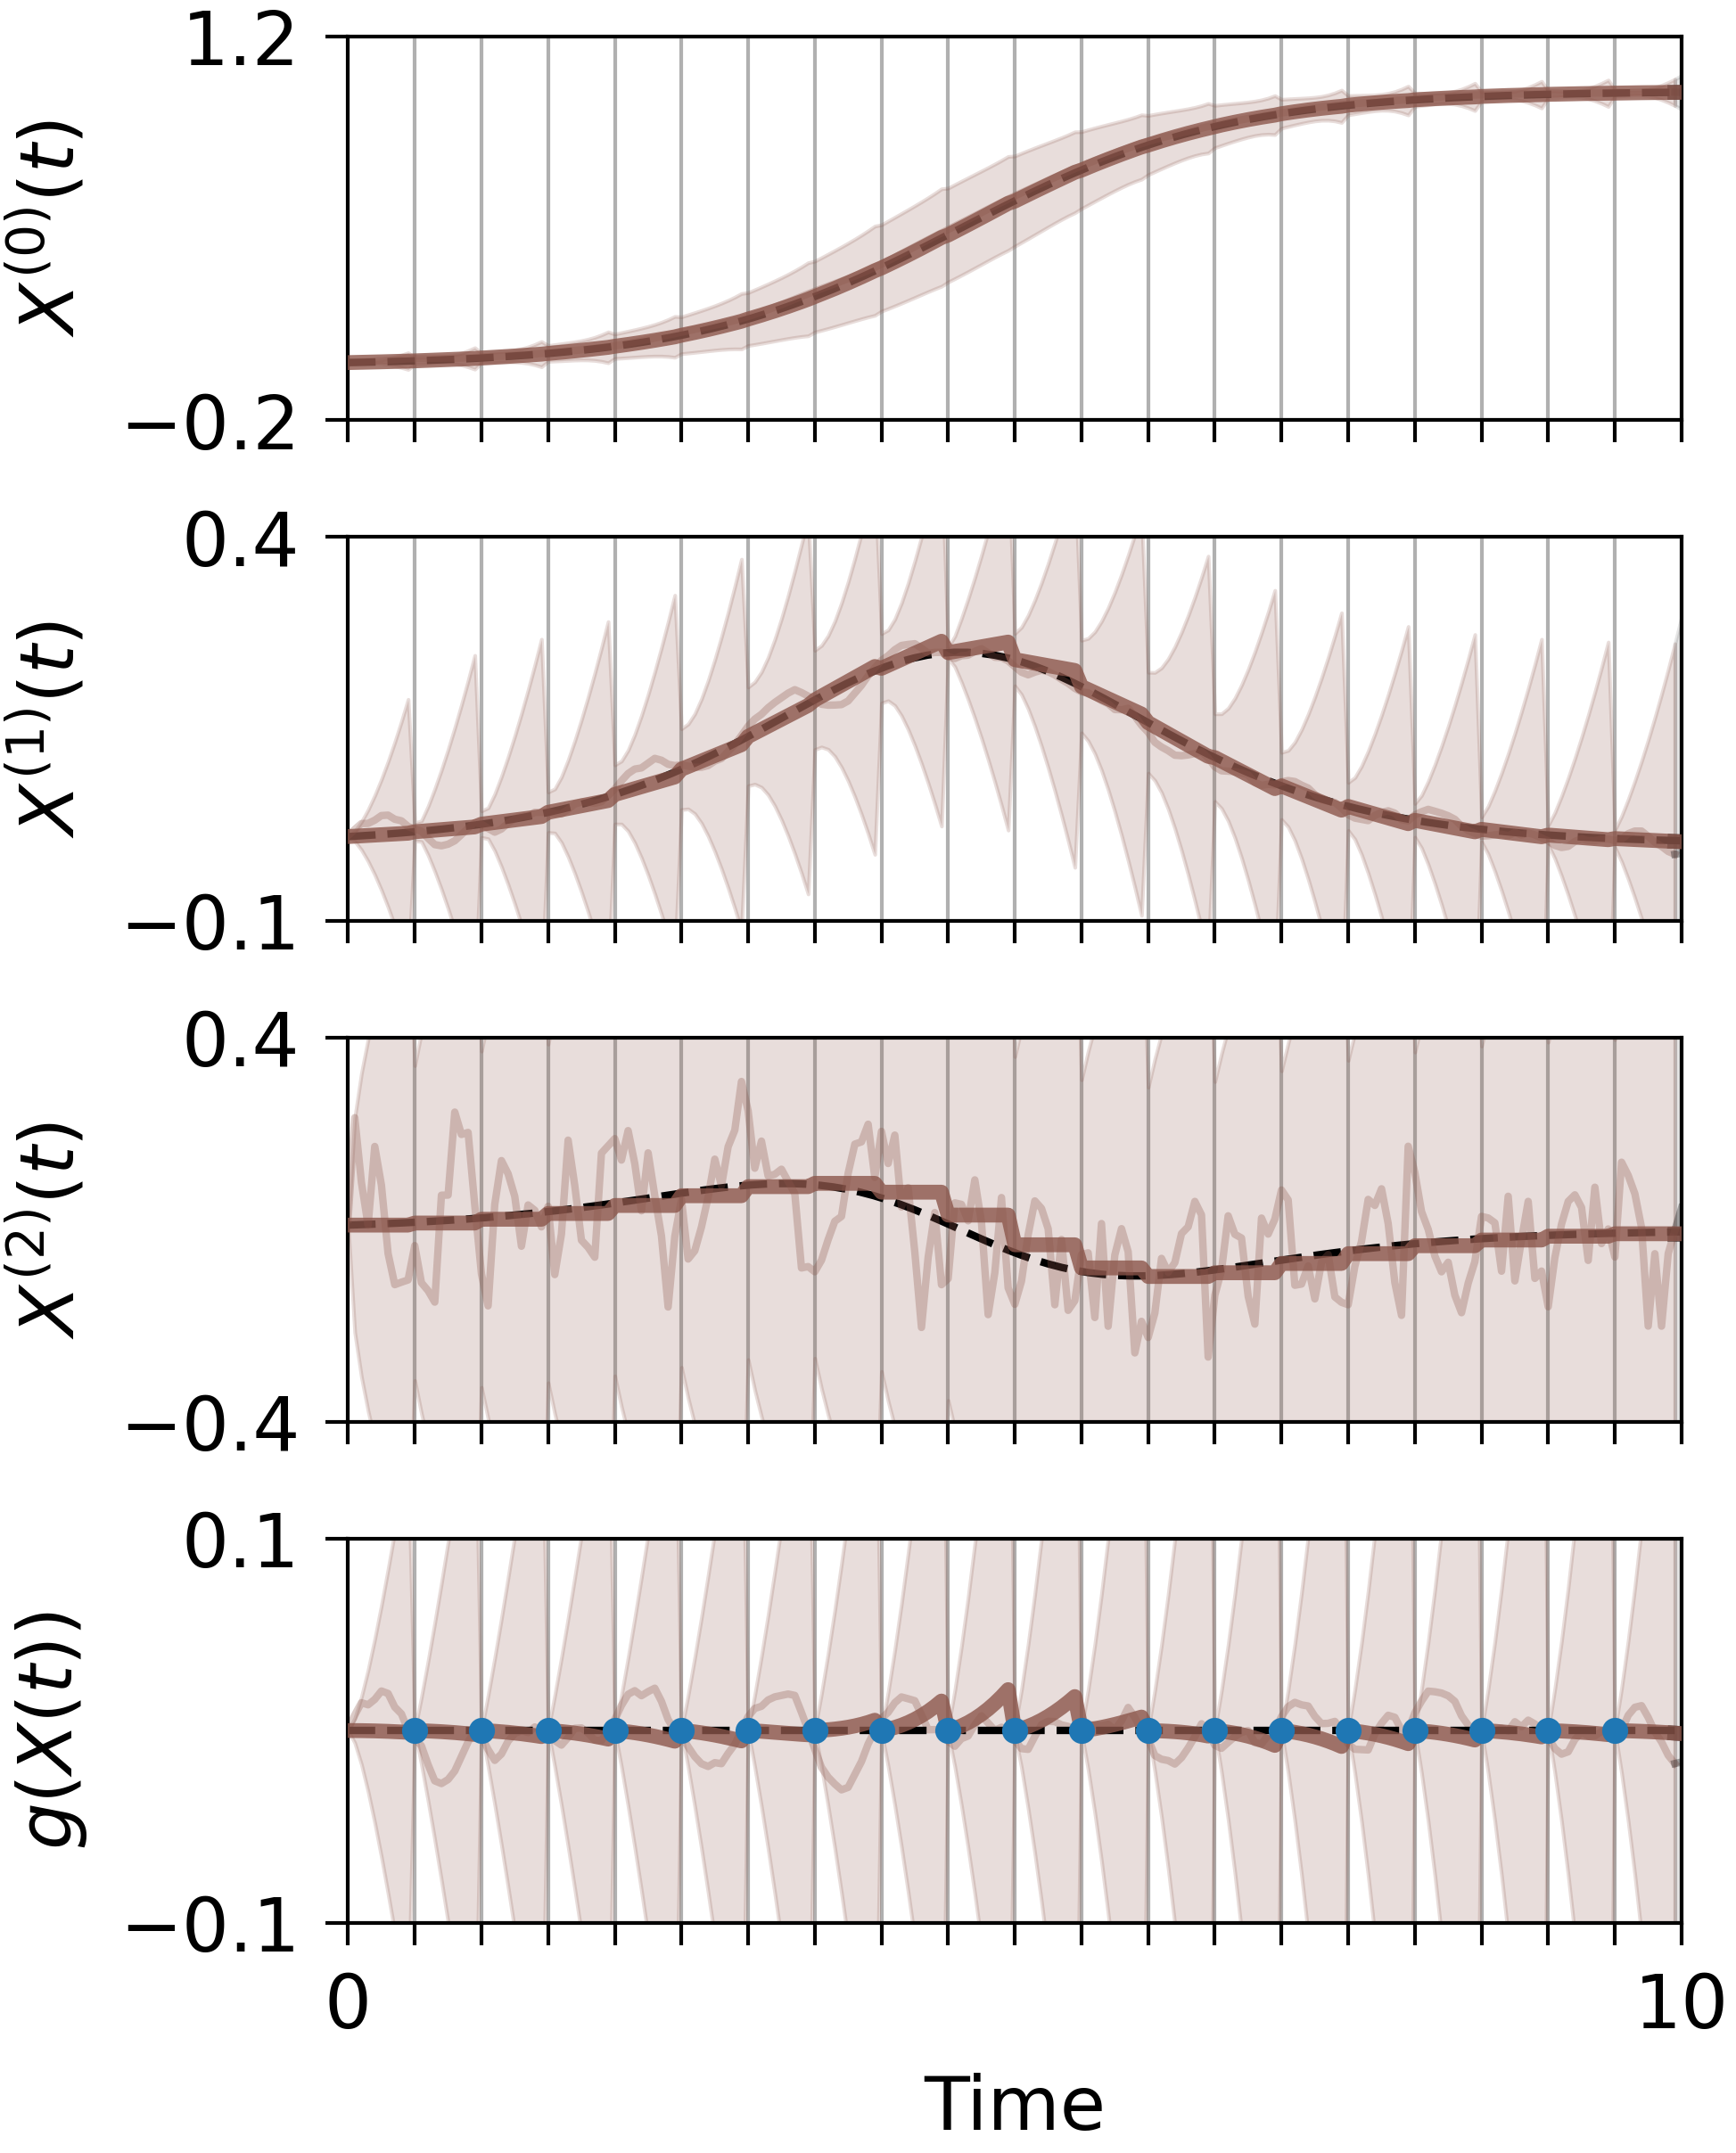

In [ ]:
create_forward_plot_with_intermediate_samples(M-1, h2, ts, ts2, N, M, num_samples=1)

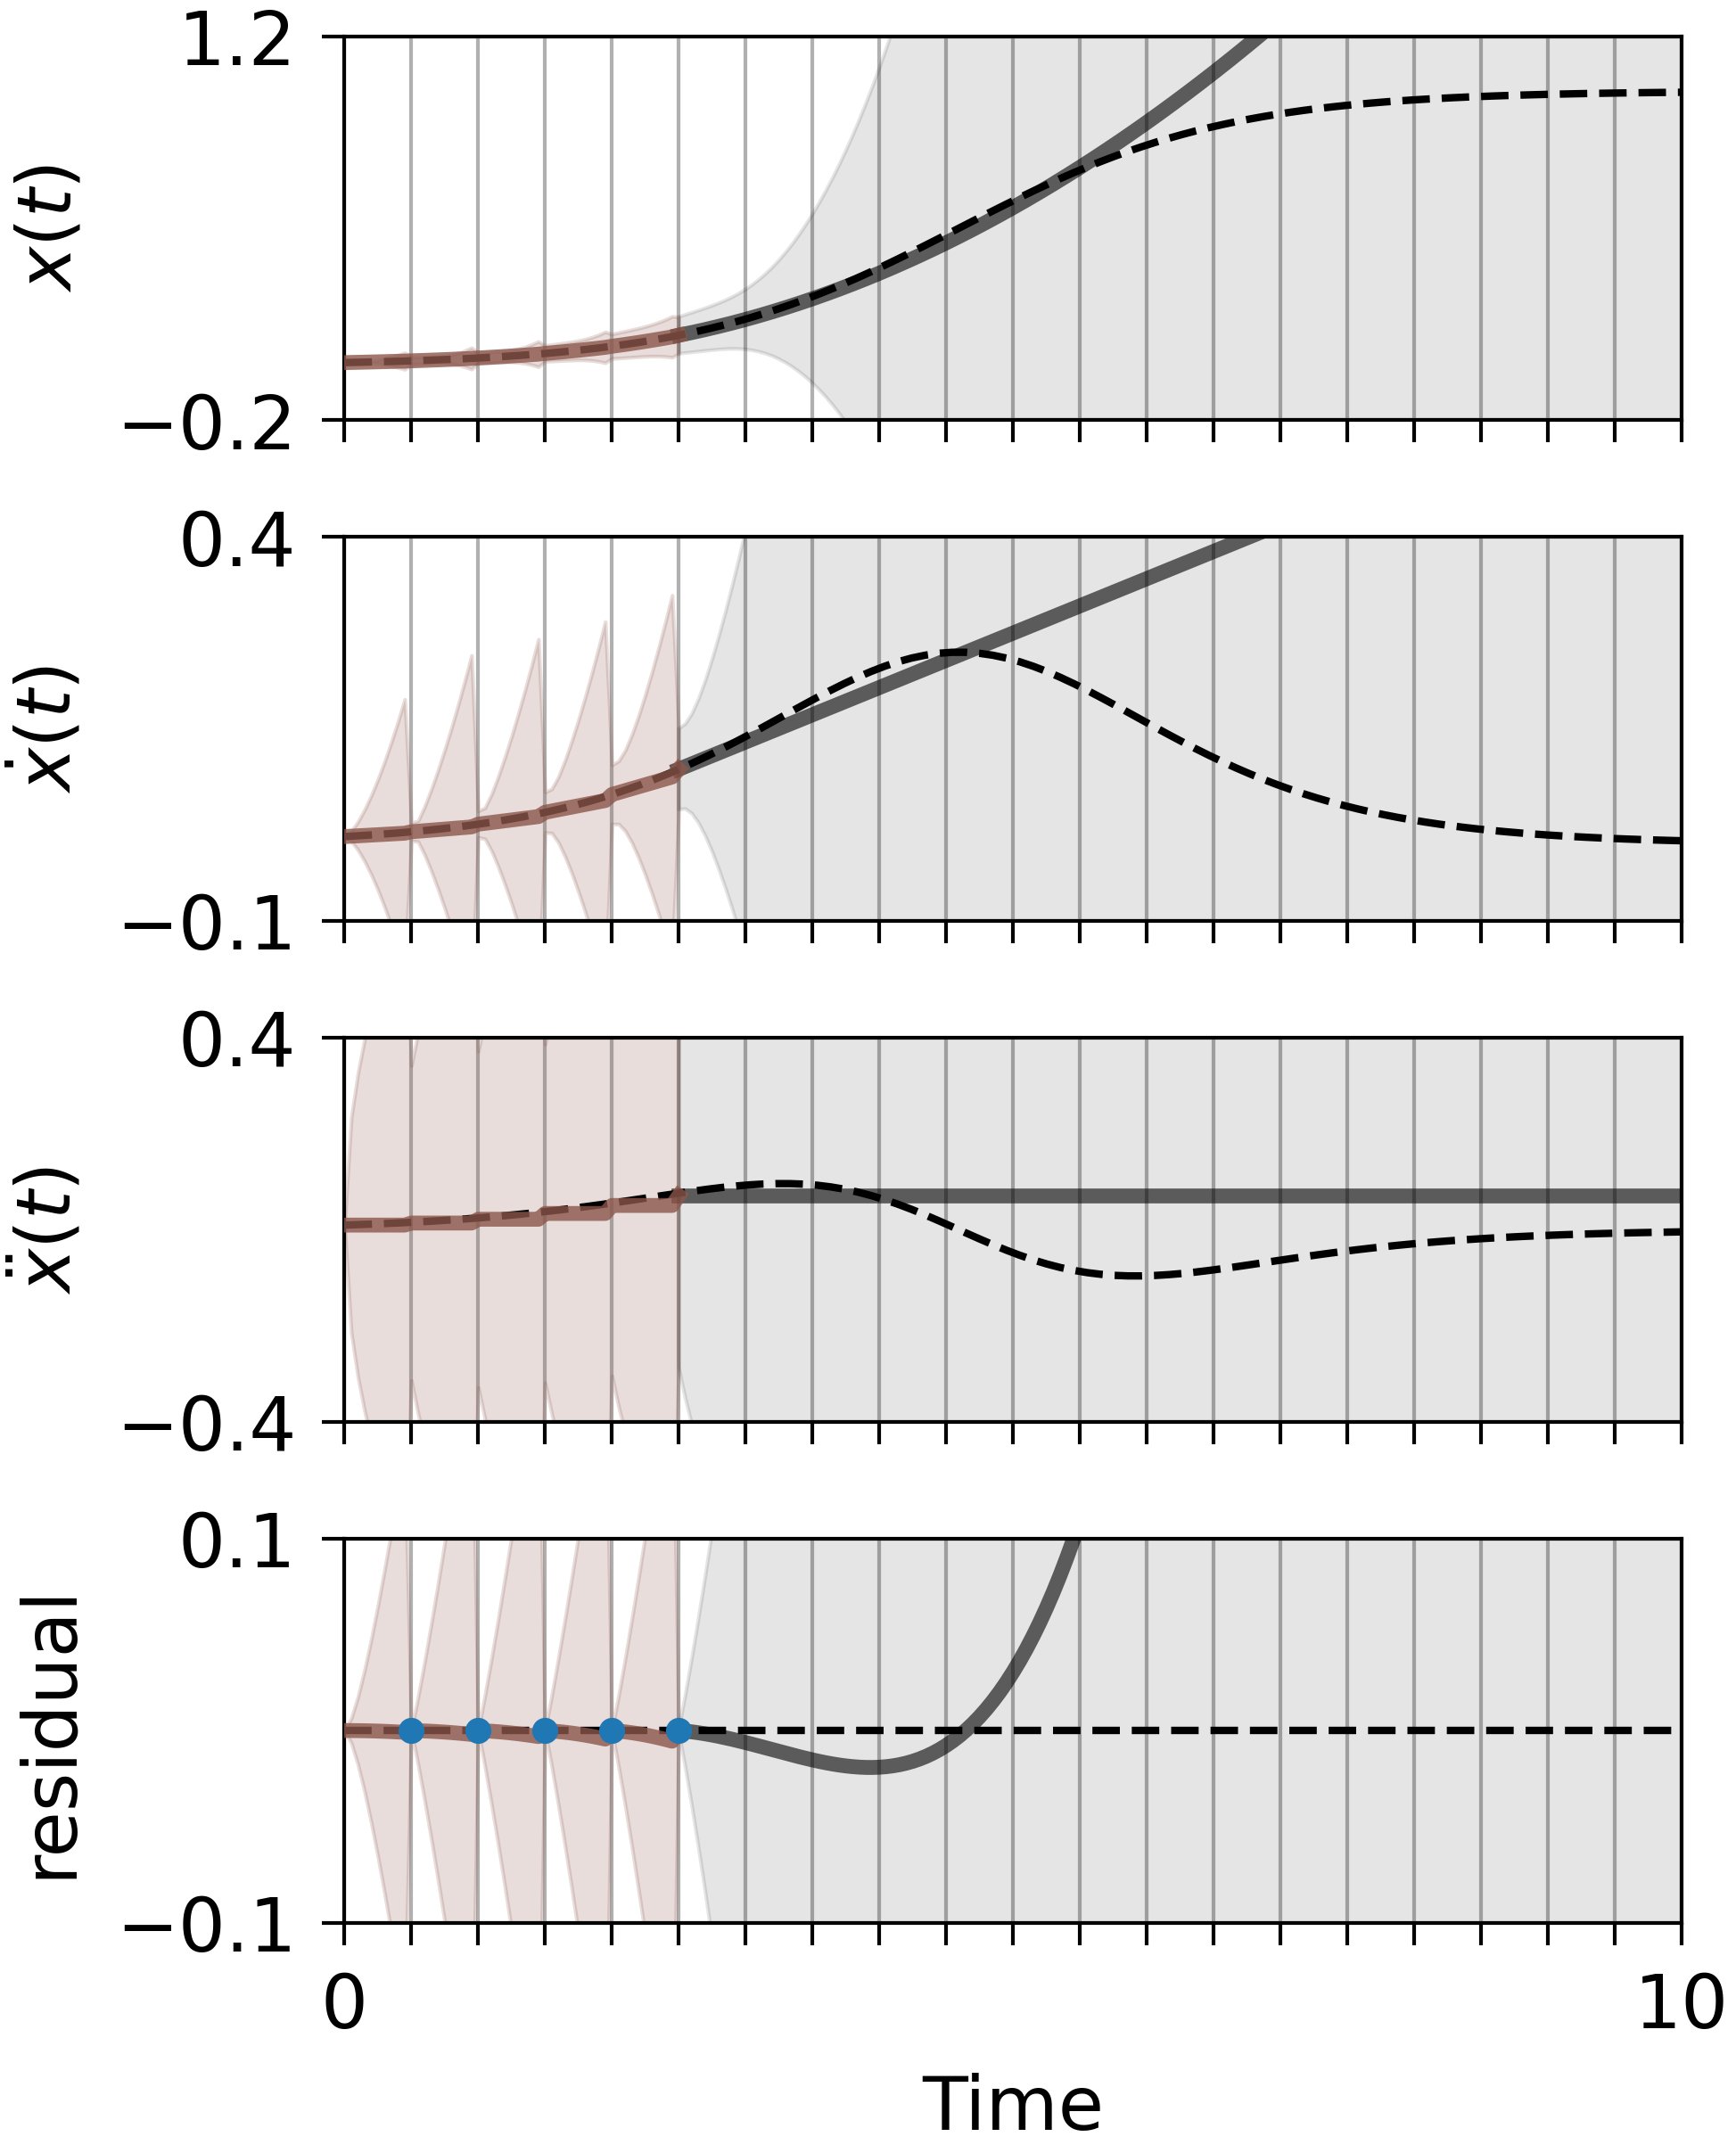

In [ ]:
create_forward_plot_with_intermediate(50, h2, ts, ts2, N, M)

In [ ]:
for i in tqdm(range(M+1)):
    create_forward_plot_with_intermediate(i, h2, ts, ts2, N, M, savefig=True)

100%|██████████| 201/201 [01:08<00:00,  2.95it/s]


In [ ]:
#now with smoothing
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h2, M)


zs_smoothed = m_smoothed[:,1] - m_smoothed[:,0]*(1 - m_smoothed[:,0])
# Uncertainty via linearization
zf_var_smoothed = []
for k in range(m_smoothed.shape[0]):
    Jk = jacobian_g(m_smoothed[k, :])
    zf_var_smoothed.append(Jk @ P_smoothed[k, :] @ Jk.T)
zf_var_smoothed = np.maximum(np.array(zf_var_smoothed).reshape(-1), 0)

### Iterative backward plotting

In [ ]:
def plot_ax_with_smooth2(ts, m, P, t, x_exact, m_smoothed, P_smoothed, k, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color=colors[5], label="filtered estimate",zorder=8, alpha=0.8, linewidth=2)
    ax.plot(ts[k-1:], m_smoothed[k-1:], color=colors[6], label="smoothed estimate", zorder=9, alpha=0.8, linewidth=2)
    #ax.scatter(ts, m, color=colors[5], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    margin_smoothed = 2*np.sqrt(P_smoothed)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color=colors[5]) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_smoothed[k-1:] - margin_smoothed[k-1:], m_smoothed[k-1:] + margin_smoothed[k-1:], alpha=0.2, color=colors[6])#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [ ]:
def create_backward_plot(k, h, ts, ts2, N, M, savefig=False):

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_smooth2(ts2, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_smoothed[:,0], P_smoothed[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_smooth2(ts2, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_smoothed[:,1], P_smoothed[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_smooth2(ts2, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_smoothed[:,2], P_smoothed[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    for i in range(3):
        # Styling to match other helper
        #axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(True)


    axs[0].set_ylabel(r'$x(t)$')
    axs[1].set_ylabel(r'$\dot{x}(t)$')
    axs[2].set_ylabel(r'$\ddot{x}(t)$')
    axs[3].set_ylabel('residual')

    plot_ax_with_smooth2(ts2, zs, zf_var, t, np.zeros_like, zs_smoothed, zf_var_smoothed, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='.', color=colors[0], zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    #axs[-1].set_ylabel('$g(X(t))$')
    axs[-1].set_xticks(ts)
    axs[-1].grid(True)  # Enable gridlines for the last plot

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        he, l = ax.get_legend_handles_labels()
        handles.extend(he)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_smoother_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

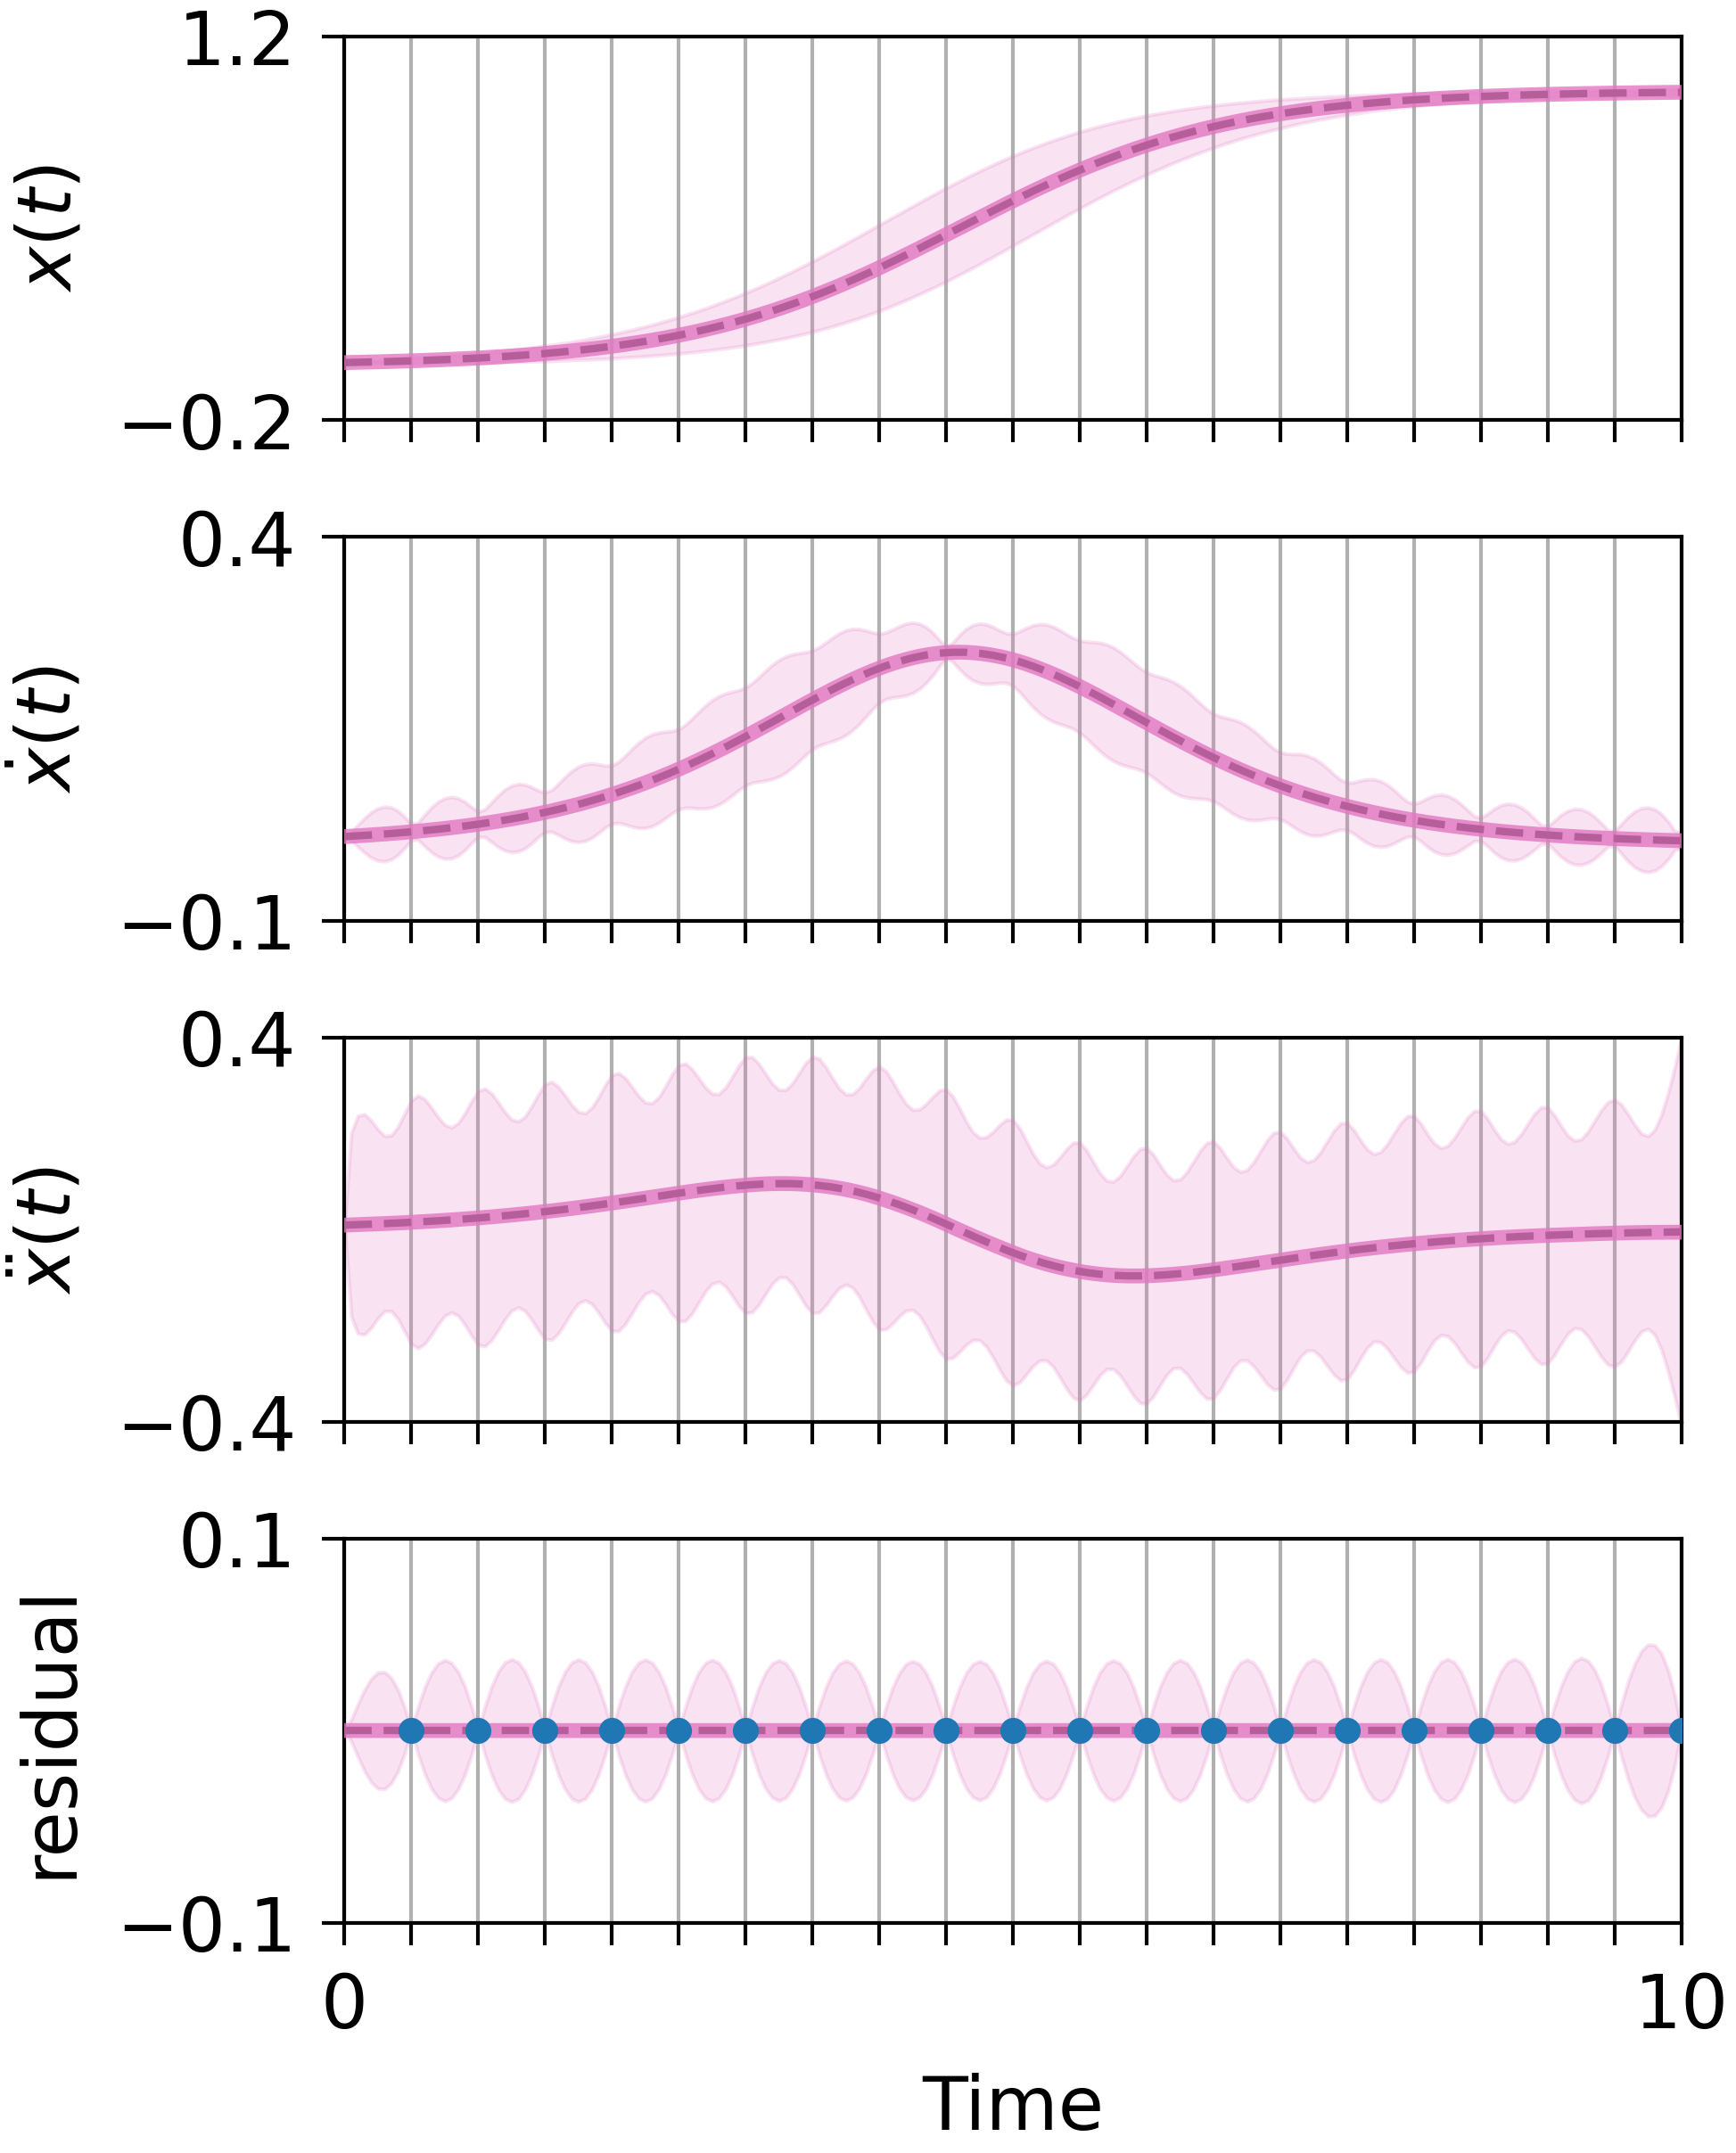

In [ ]:
create_backward_plot(1, h2, ts, ts2, N, M)

In [ ]:
for i in tqdm(range(1,M+1)):
    create_backward_plot(i, h2, ts, ts2, N, M, savefig=True)

100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


In [ ]:
def create_backward_plot_with_samples(h, ts, ts2, N, M, savefig=False, num_samples=5, seed=42):

    k=1
    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_smooth2(ts2, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], m_smoothed[:,0], P_smoothed[:,0,0], k, x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
    plot_ax_with_smooth2(ts2, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], m_smoothed[:,1], P_smoothed[:,1,1], k, x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
    plot_ax_with_smooth2(ts2, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], m_smoothed[:,2], P_smoothed[:,2,2], k, x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

    # Prefix-stable sampling: per-sample seeding so prefixes are identical across calls
    x_backw_list = []
    for j in range(num_samples):
        rng = np.random.default_rng(seed + j)
        # sample at current position using per-sample RNG
        x_k_j = rng.multivariate_normal(m_sequence[-1, :], P_sequence[-1, ...])
        # if downstream uses np.random, align its state for this sample j
        np.random.seed(seed + j)
        # sample backward path from backward transitions
        x_backw_j = sample_backward_transitions(q, M+1, h, x_k_j, Gs, ds, Lambdas)
        x_backw_list.append(x_backw_j)

    x_backw = np.moveaxis(np.array(x_backw_list), 0, -1)


    for i in range(3):
        # Styling to match other helper
        #axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(True)
        
        #add sample plots
        axs[i].plot(ts2, x_backw[:,i], color=colors[6], alpha=0.3)

    axs[3].plot(ts2, x_backw[:,1]-x_backw[:,0]*(1-x_backw[:,0]), color=colors[6], alpha=0.3)

    axs[0].set_ylabel(r'$x(t)$')
    axs[1].set_ylabel(r'$\dot{x}(t)$')
    axs[2].set_ylabel(r'$\ddot{x}(t)$')
    axs[3].set_ylabel('residual')

    plot_ax_with_smooth2(ts2, zs, zf_var, t, np.zeros_like, zs_smoothed, zf_var_smoothed, k, x_lim=[0,10], y_lim=[-0.1, 0.1], ax=axs[-1])
    axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='.', color=colors[0], zorder=10)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])
    #axs[-1].set_ylabel('$g(X(t))$')
    axs[-1].set_xticks(ts)
    axs[-1].grid(True)  # Enable gridlines for the last plot

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        he, l = ax.get_legend_handles_labels()
        handles.extend(he)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.825, 0.94), ncol=1, frameon=True)

    if savefig:
        plt.savefig(f"ODE_smoother_imgs/img_{num_samples}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
for i in tqdm(range(1,101)):
    create_backward_plot_with_samples(h, ts, ts2, N, M, savefig=True, num_samples=i, seed=42)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


### Sample paths from full posterior

In [ ]:
Gs, ds, Lambdas = backward_transitions(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)
#sample backward transitions

In [ ]:
X_s_samples = backward_sample_paths(5, m_sequence, P_sequence, Gs, ds, Lambdas, N, seed=444)

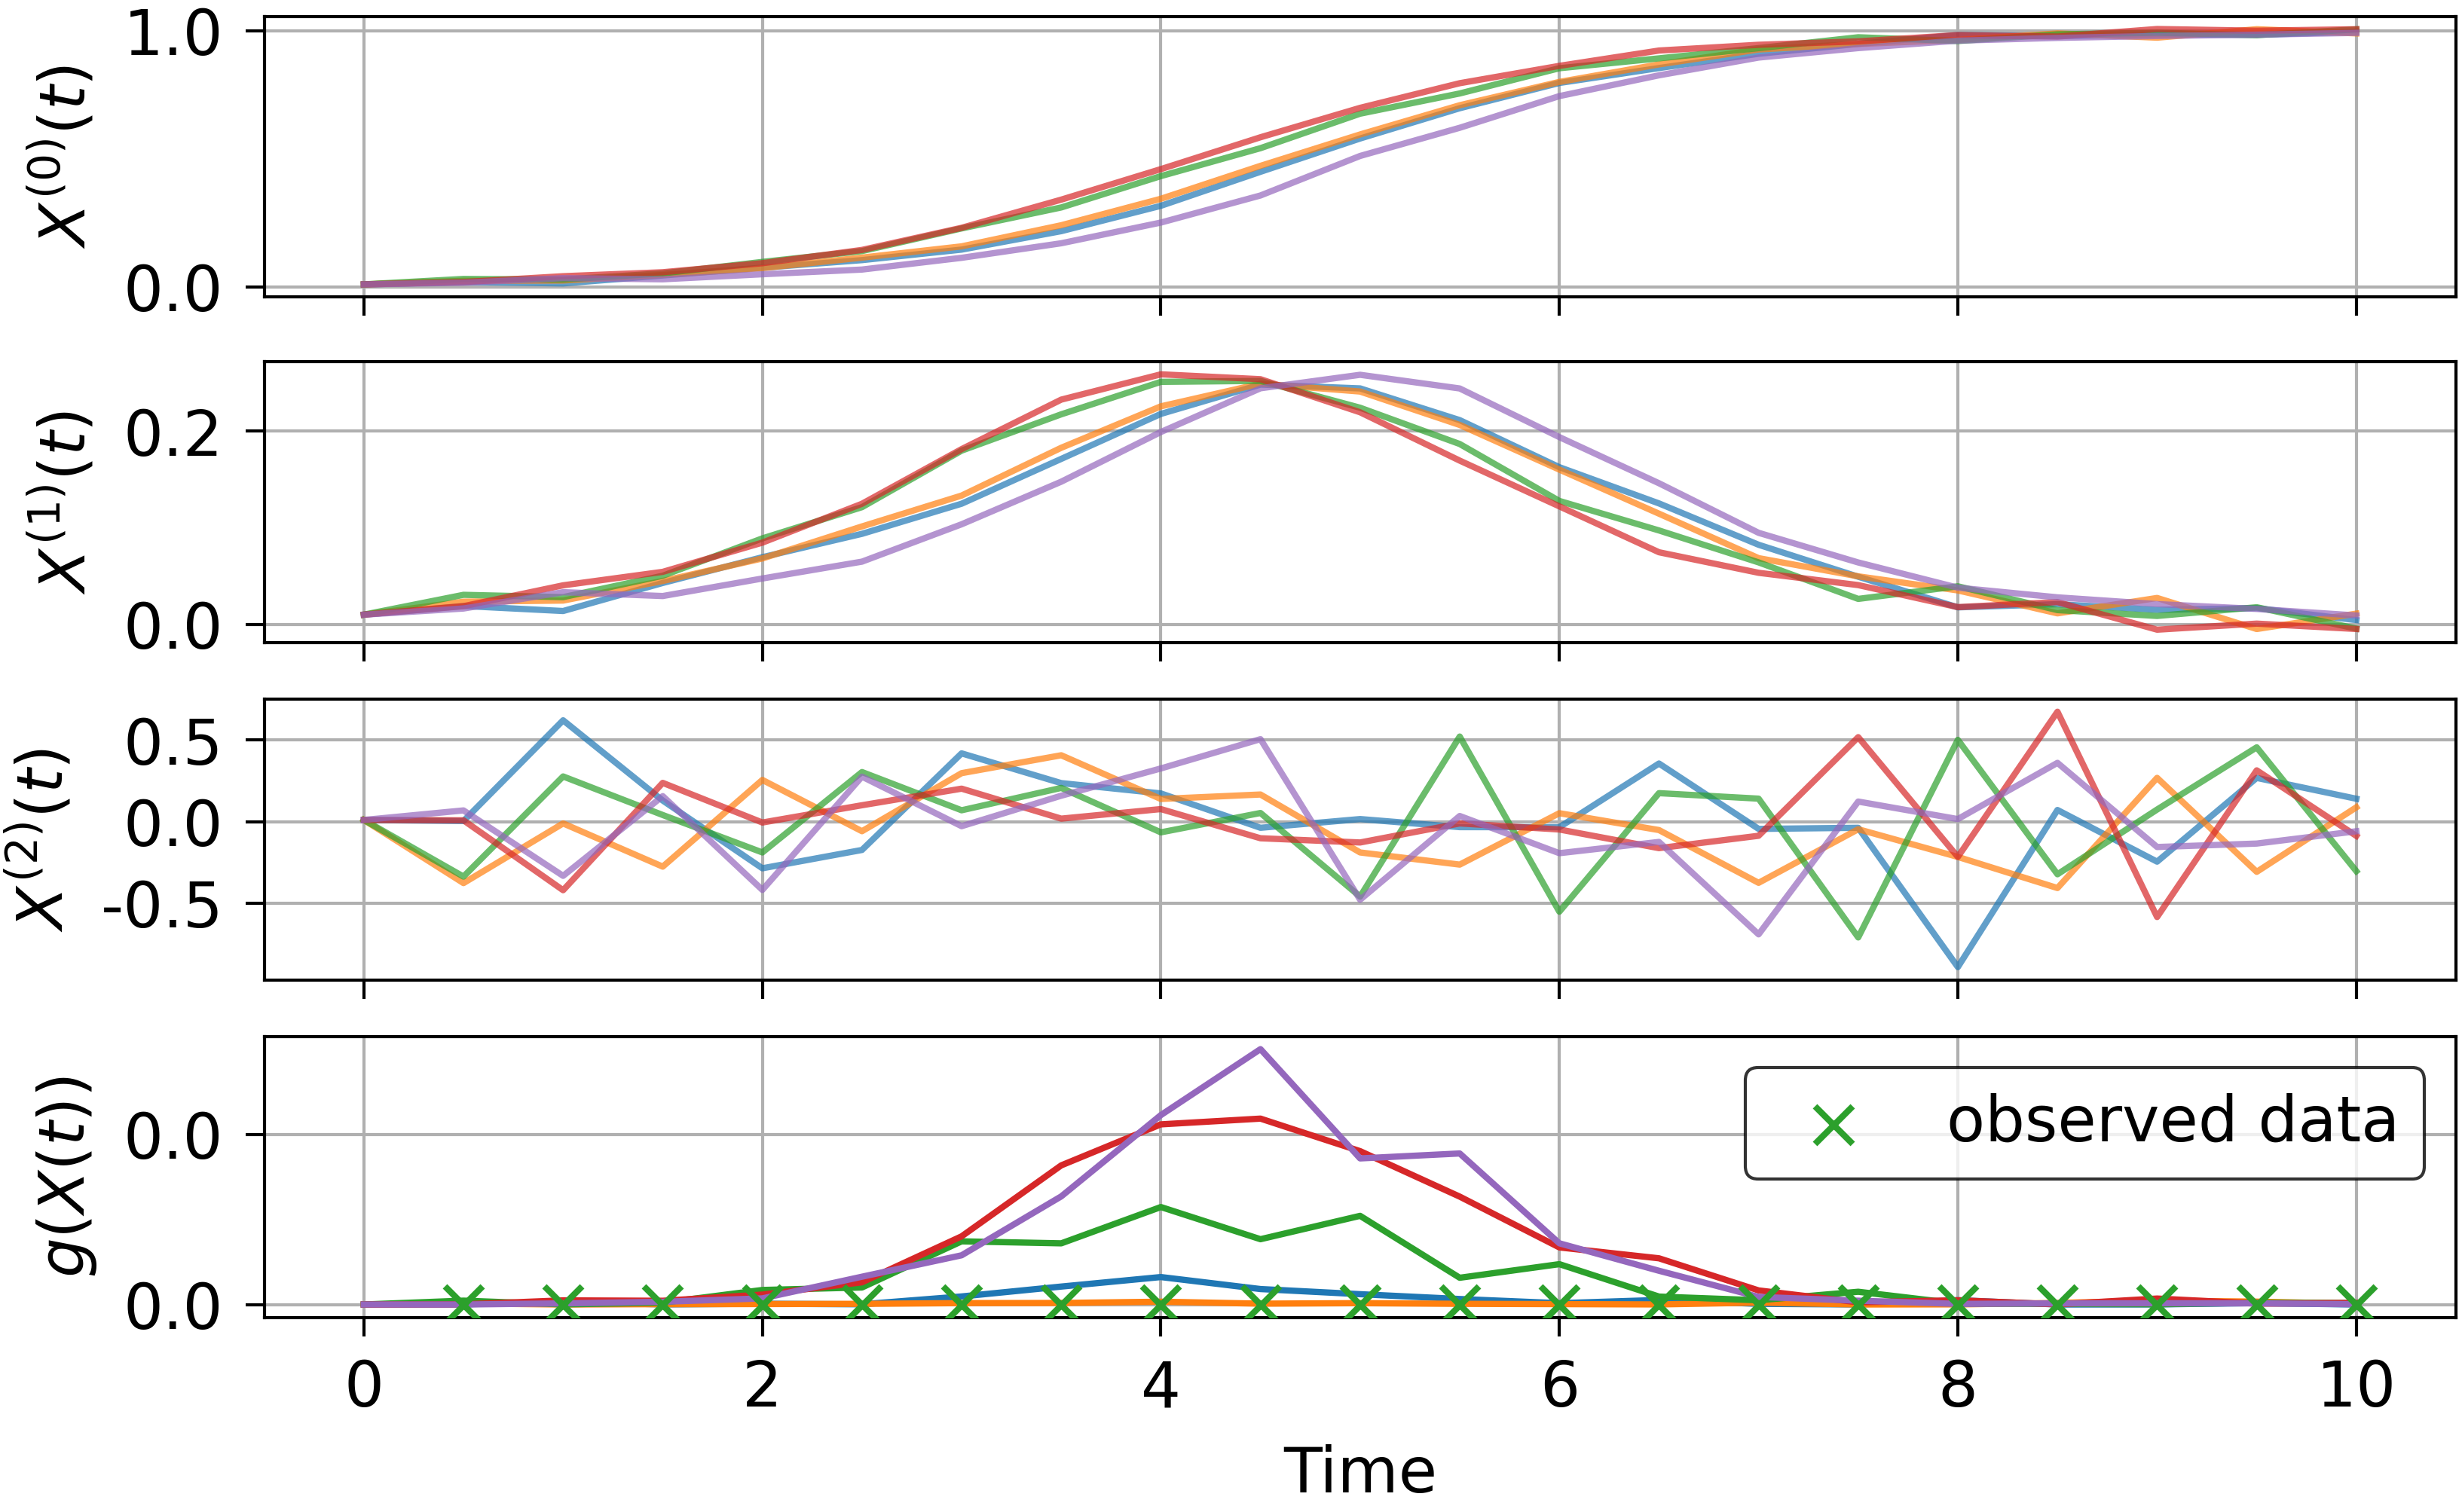

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True)

# Plot the three state variables
for i in range(3):
    for s in range(X_s_samples.shape[0]):
        axs[i].plot(ts, X_s_samples[s, :, i], alpha=0.7, label=f'Sample {s+1}' if i == 0 else None)
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].grid(True)
    # Set ytick labels to have the same number of decimal points (e.g., 4)
    axs[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Plot z = g(x) in the fourth subplot
# Compute z for each sample: z = x0 * x1 * x2
z_samples = X_s_samples[:, :, 1] - X_s_samples[:, :, 0] * (1 - X_s_samples[:, :, 0])
for s in range(X_s_samples.shape[0]):
    axs[3].plot(ts, z_samples[s])
# Optionally, plot the observed z data if available
if 'z_sequence' in locals():
    axs[3].scatter(ts[1:], z_sequence, label="observed data", marker='x', color=colors[0], zorder=10)
axs[3].set_ylabel('$g(X(t))$')
axs[3].set_xlabel('Time')
axs[3].grid(True)
axs[3].legend(loc='upper right')
# Set ytick labels to have the same number of decimal points (e.g., 4)
axs[3].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.show()


### Tabular Plot prior data posterior

In [ ]:
num_samples = 5

In [ ]:
#function that samples q-times IWP path
def sample_IWP_path(q, N, h, y0=None):

    mu_0 = np.zeros(q)
    Sigma_0 = np.eye(q)*0.01
    if y0 != None:
        mu_0[0] = y0
        Sigma_0[0,0] = 0
    x = np.zeros((N, q))
    x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], 0.01*Q(h))
    return x


#function that samples q-times IWP path from initialiyation x_0
def sample_IWP_path_from_taylor_modes(q, N, h, x_0):

    x = np.zeros((N, q))
    x[0,:] = x_0

    for i in range(1, N):
        #TODO: the *0.01 is for visualization purpose sucht that the first two rows dont blow up to much and can be displayed on the same axis as the ground truth
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], 0.01*Q(h))
    return x

In [ ]:

x_samples_IWP = np.array([sample_IWP_path(3, N+1, h) for _ in range(num_samples)])

In [ ]:
#X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])

x_samples_IWP_taylor = np.array([sample_IWP_path_from_taylor_modes(3, N+1, h, X_0) for _ in range(num_samples)])

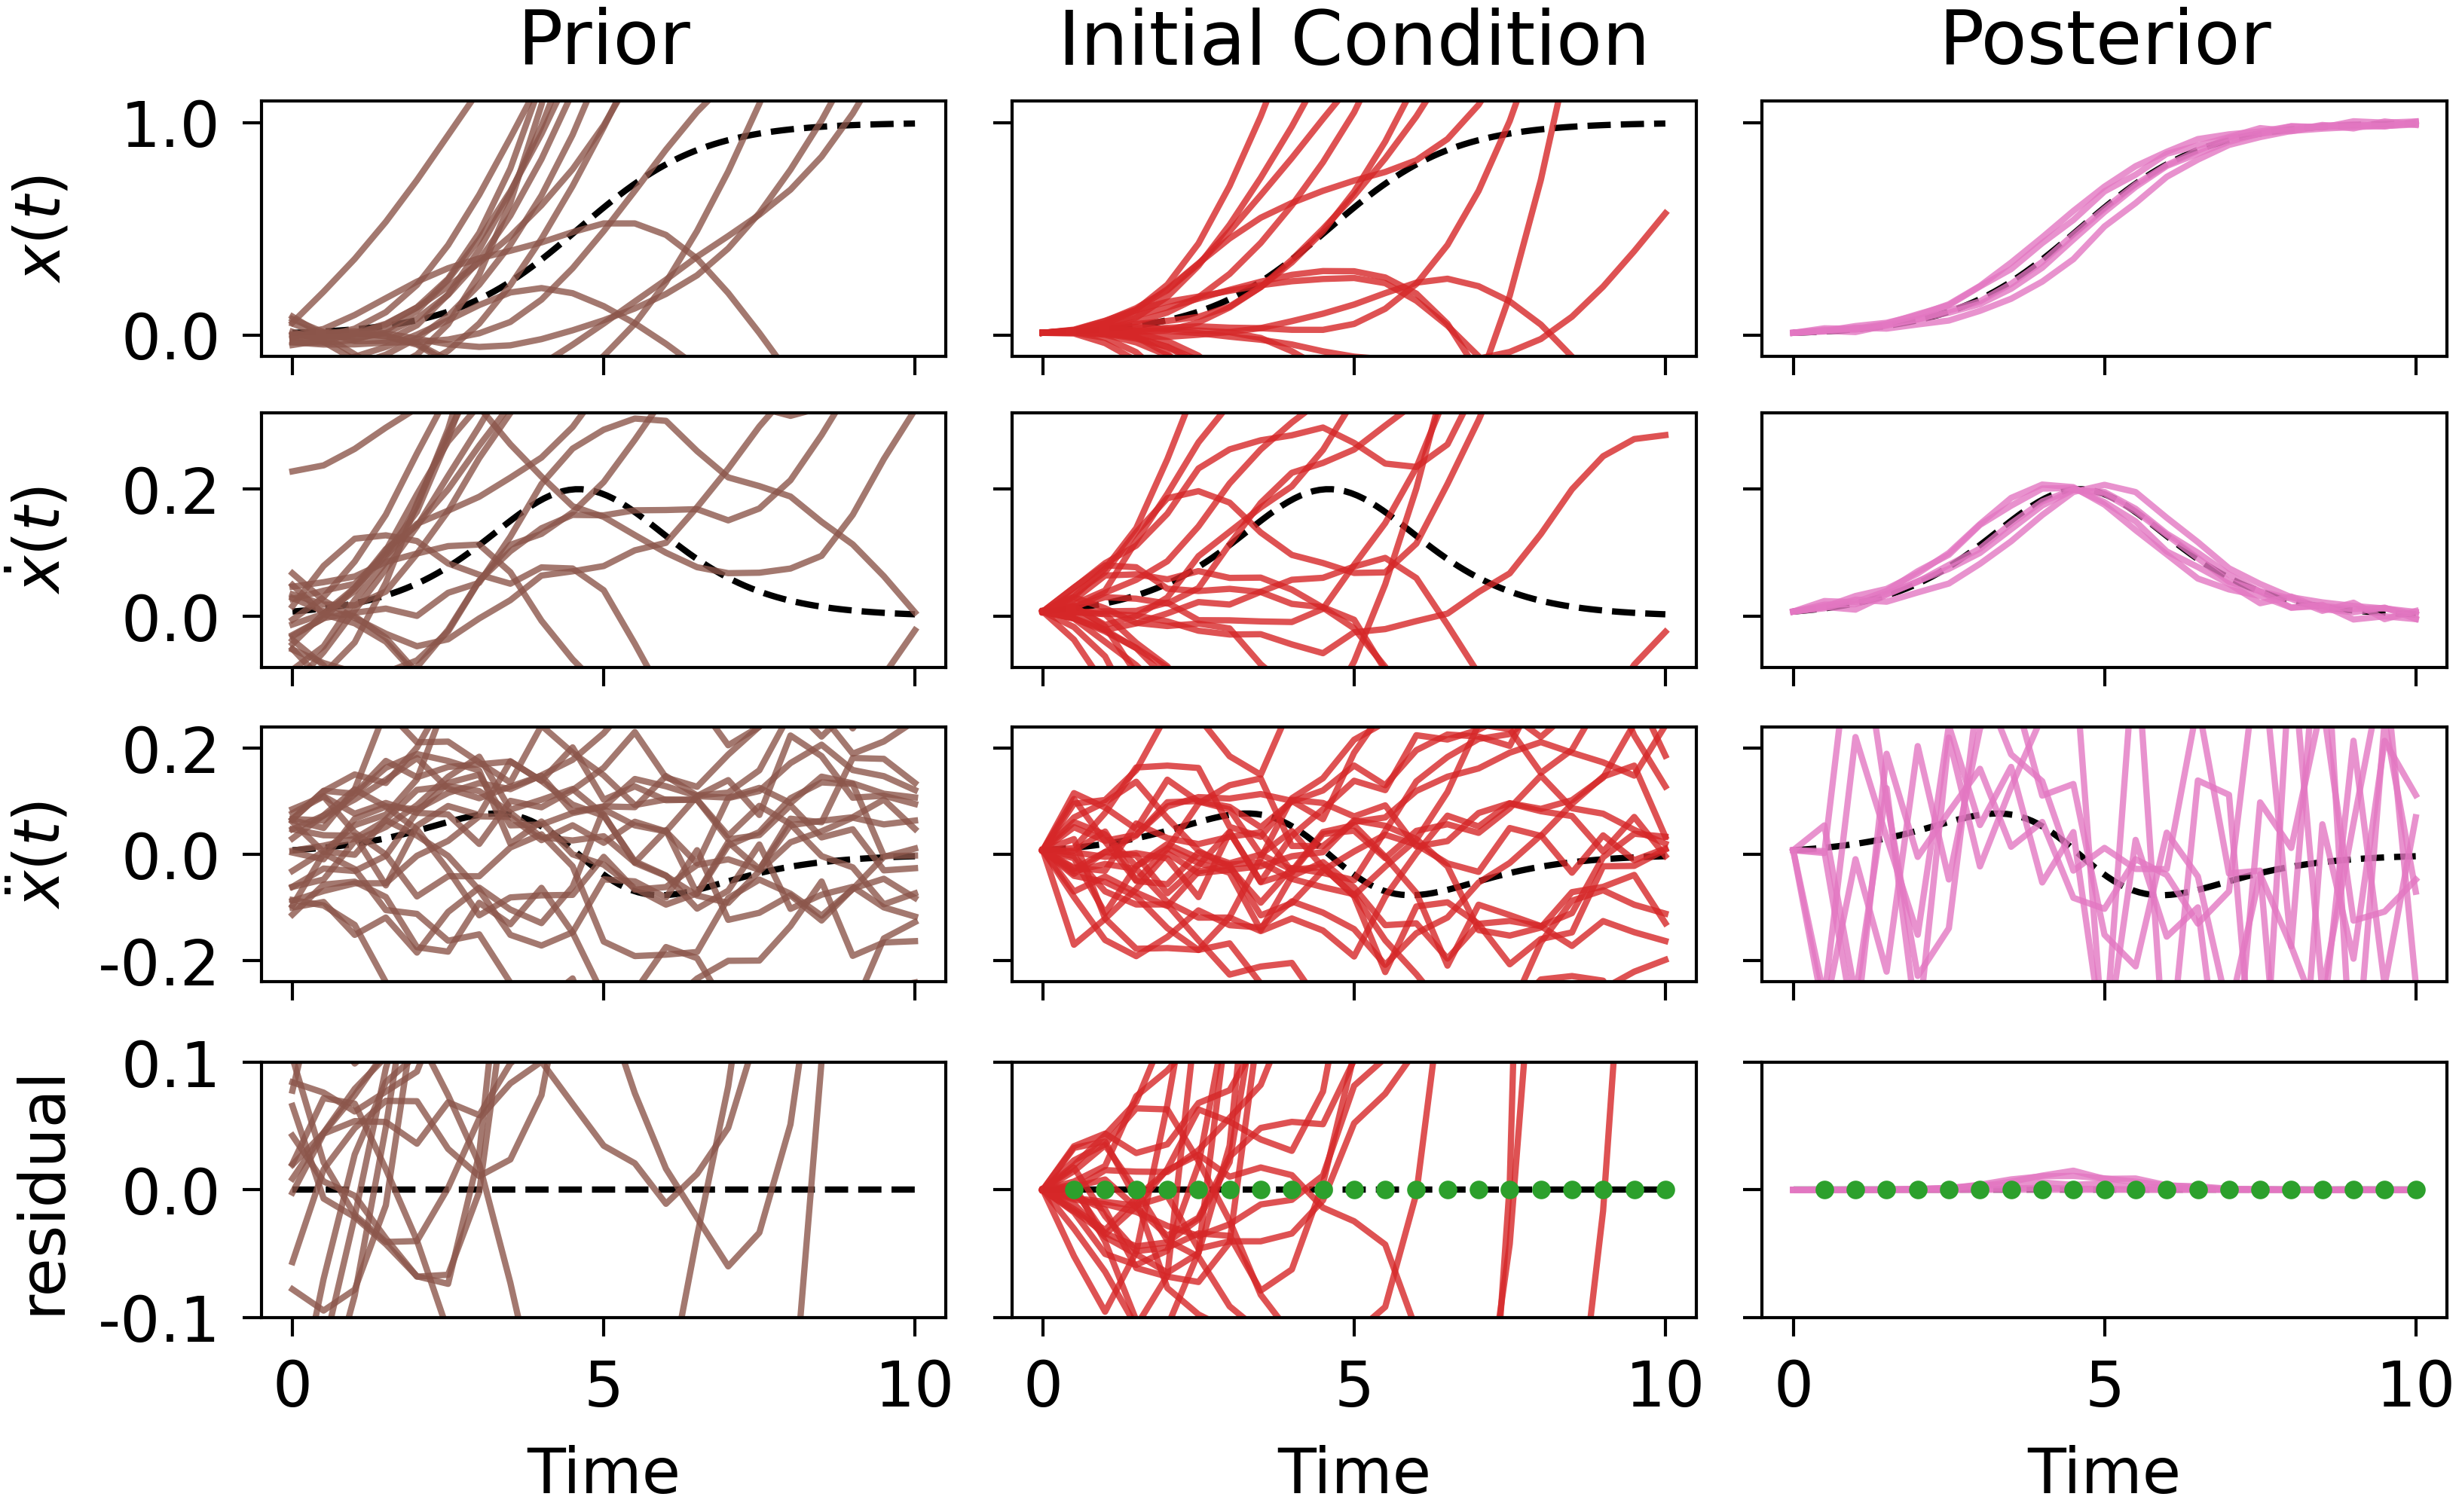

In [ ]:
# Create 4x3 subplot comparison: Prior, Initial Condition, Posterior
fig, axs = plt.subplots(4, 3, sharex=True)

# Configuration for each comparison type
sample_data = [
    (x_samples_IWP, colors[5], "Prior"),           # Column 0
    (x_samples_IWP_taylor, colors[3], "Initial Condition"),  # Column 1  
    (X_s_samples, colors[6], "Posterior")         # Column 2
]

# Y-axis limits for each row
y_limits = [[-0.1, 1.1], [-0.1, 0.4], [-0.3, 0.3], [-0.1, 0.1]]
row_labels = [r'$x(t)$', r'$\dot{x}(t)$', r'$\ddot{x}(t)$', 'residual']

# Plot all sample types
for col, (samples, sample_color, title) in enumerate(sample_data):
    # Set column title
    axs[0, col].set_title(title)
    
    # Plot exact solutions (ground truth) for all rows
    for row in range(3):
        axs[row, col].plot(t, exact_sols[row](t), linestyle='--', color='black')
    axs[3, col].plot(t, np.zeros_like(t), linestyle='--', color='black')
    
    # Plot sample paths
    for s in range(samples.shape[0]):
        # State components (rows 0-2)
        for row in range(3):
            axs[row, col].plot(ts, samples[s, :, row], alpha=0.8, color=sample_color)
        
        # Residual (row 3) - compute based on sample type
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        axs[3, col].plot(ts, residual, alpha=0.8, color=sample_color)
    
    # Add observed data for Initial Condition and Posterior columns
    if col > 0:
        axs[3, col].scatter(ts[1:], z_sequence, label="observed data", 
                           s=6, color=colors[0], zorder=10)
    
    # Set y-axis limits and formatting
    for row in range(4):
        axs[row, col].set_ylim(y_limits[row])
        if col > 0:  # Remove y-tick labels for columns 1 and 2
            axs[row, col].set_yticklabels([])

# Set labels and formatting for leftmost column only
for row in range(4):
    axs[row, 0].set_ylabel(row_labels[row])
    axs[row, 0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Set x-axis labels for bottom row
for col in range(3):
    axs[3, col].set_xlabel('Time')

fig.align_ylabels(axs)
plt.show()

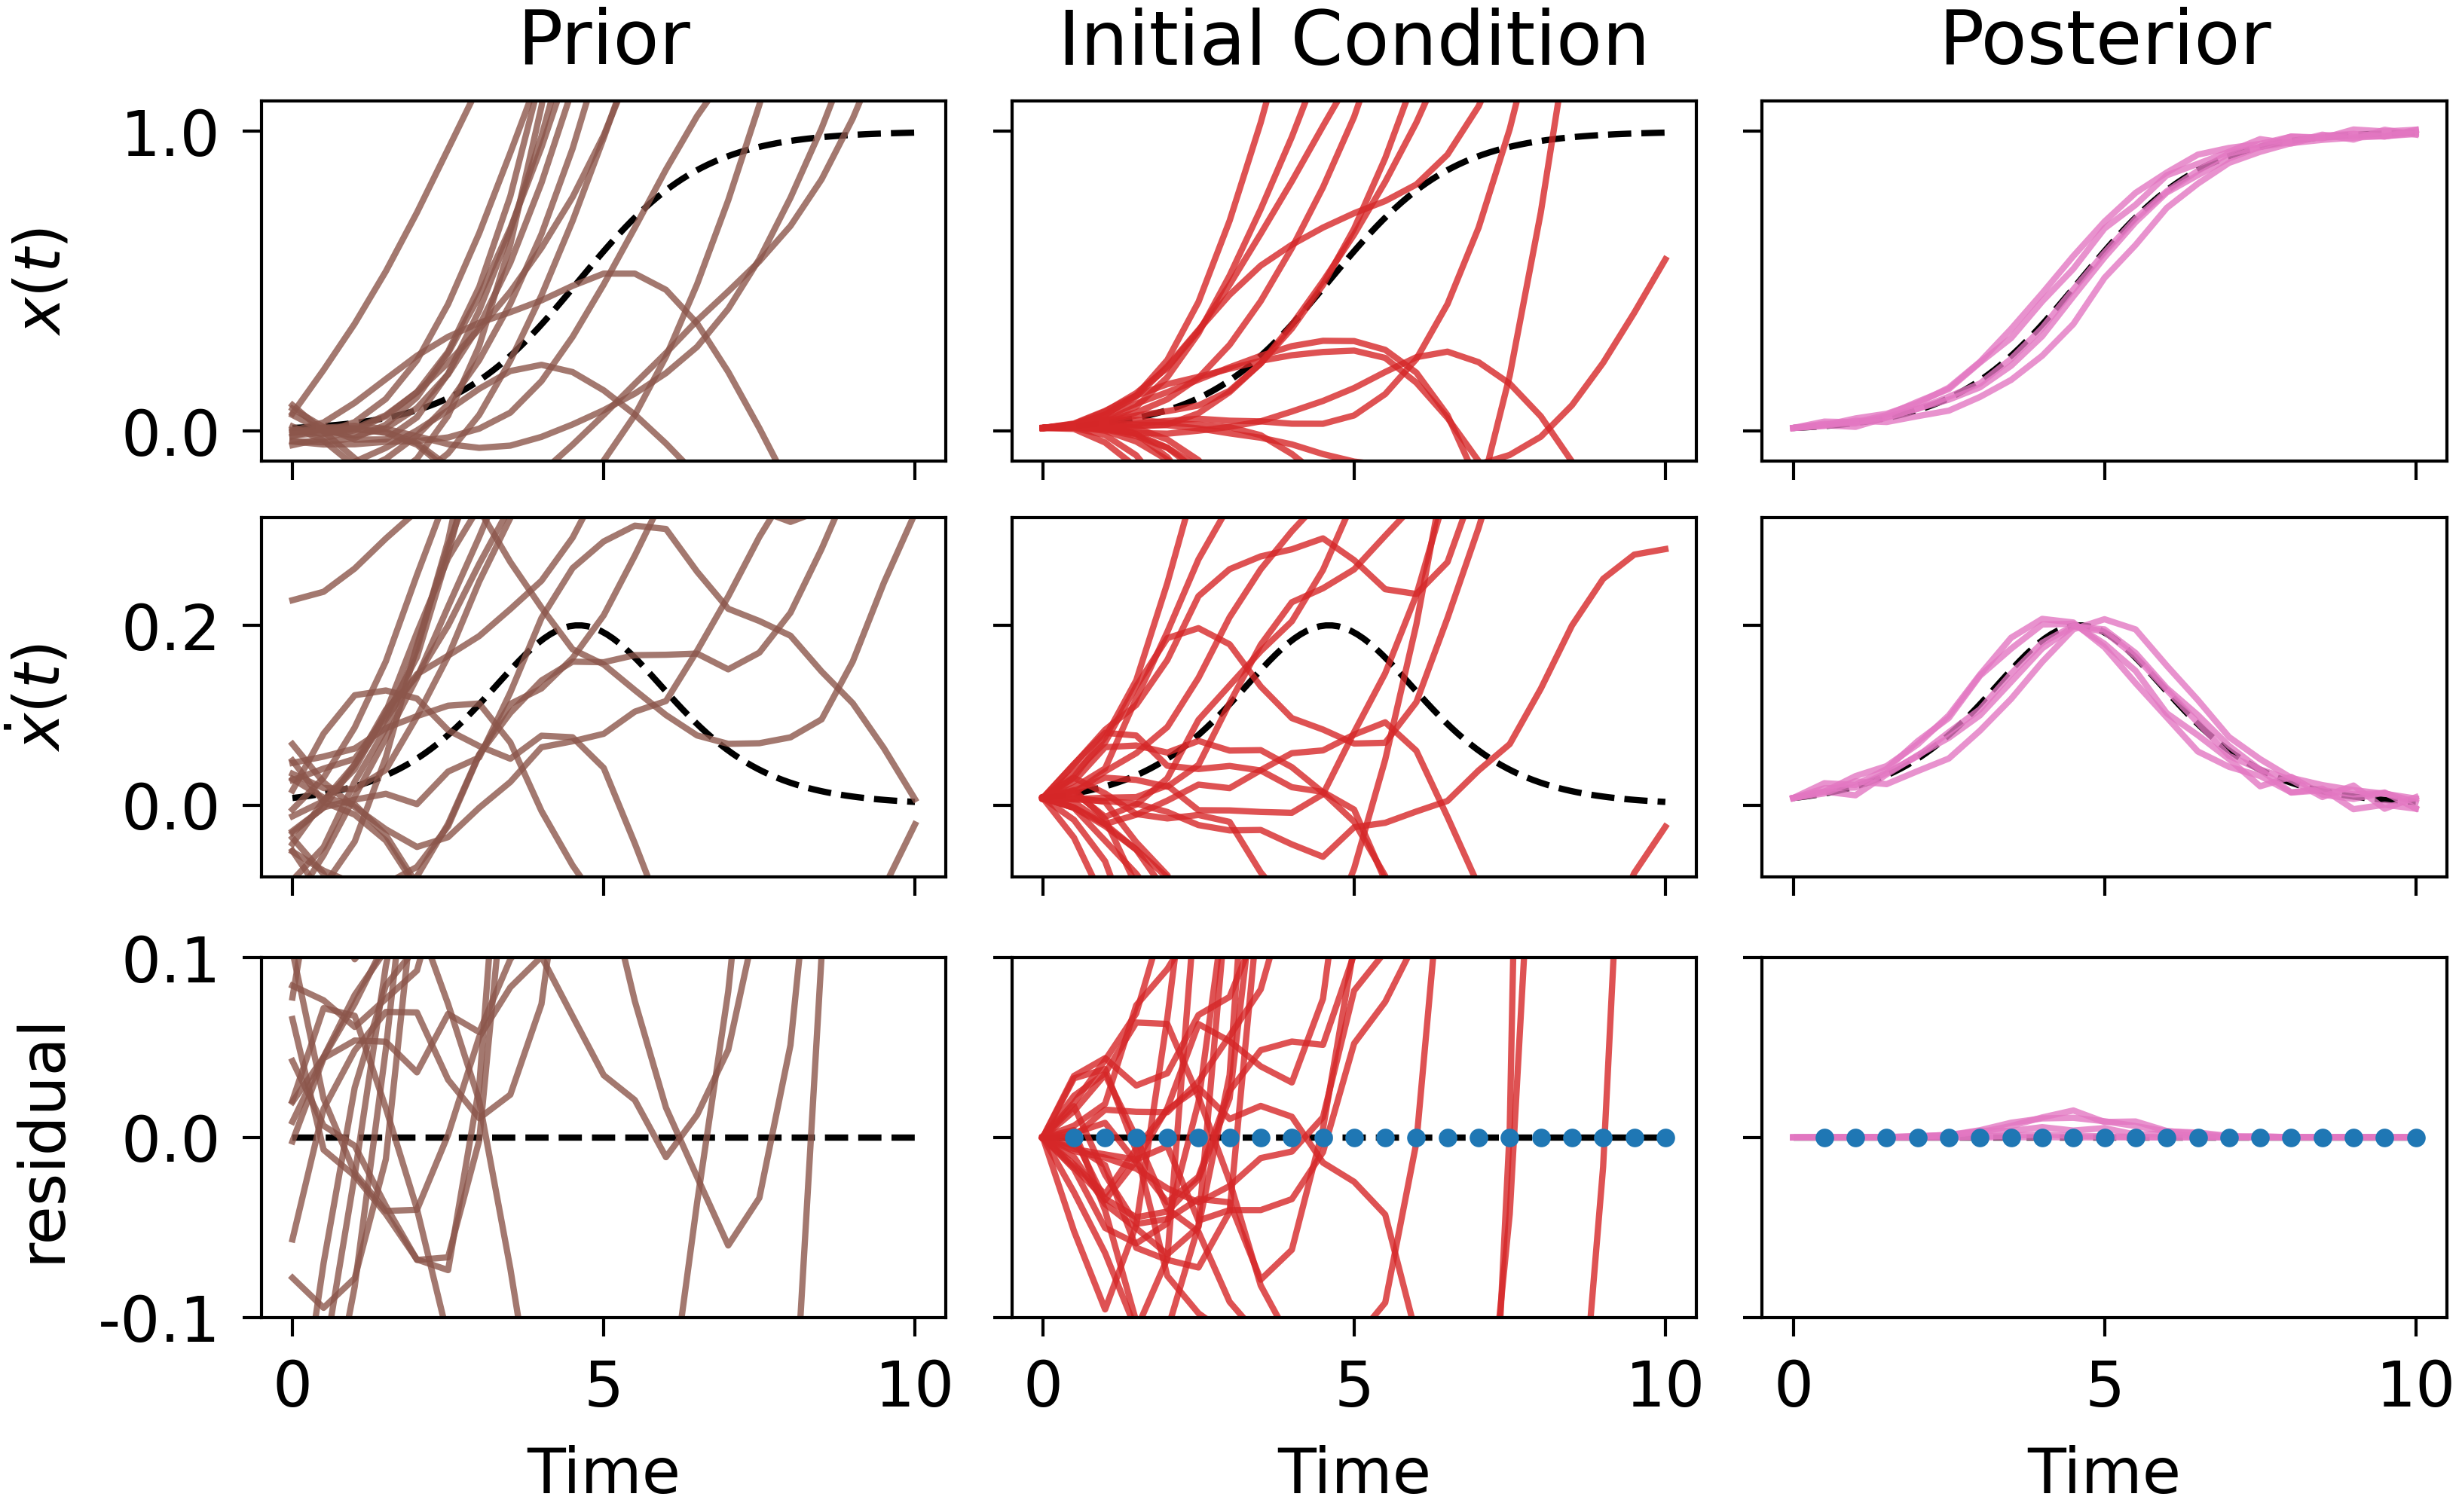

In [ ]:
# Create 3x3 subplot comparison: Prior, Initial Condition, Posterior
fig, axs = plt.subplots(3, 3, sharex=True)

# Configuration for each comparison type
sample_data = [
    (x_samples_IWP, colors[5], "Prior"),                    # Column 0
    (x_samples_IWP_taylor, colors[3], "Initial Condition"), # Column 1  
    (X_s_samples, colors[6], "Posterior")                   # Column 2
]

# Y-axis limits and labels for each row
y_limits = [[-0.1, 1.1], [-0.1, 0.4], [-0.1, 0.1]]
row_labels = [r'$x(t)$', r'$\dot{x}(t)$', 'residual']

# Plot all sample types
for col, (samples, sample_color, title) in enumerate(sample_data):
    # Set column title
    axs[0, col].set_title(title)
    
    # Plot exact solutions (ground truth)
    axs[0, col].plot(t, exact_sols[0](t), linestyle='--', color='black')
    axs[1, col].plot(t, exact_sols[1](t), linestyle='--', color='black')
    axs[2, col].plot(t, np.zeros_like(t), linestyle='--', color='black')
    
    # Plot sample paths
    for s in range(samples.shape[0]):
        # First two state components
        for row in range(2):
            axs[row, col].plot(ts, samples[s, :, row], alpha=0.8, color=sample_color)
        
        # Residual (bottom row) - compute based on sample type
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        axs[2, col].plot(ts, residual, alpha=0.8, color=sample_color)
    
    # Add observed data for Initial Condition and Posterior columns
    if col > 0:
        axs[2, col].scatter(ts[1:], z_sequence, label="observed data", 
                           s=6, color=colors[5], zorder=10)
    
    # Set y-axis limits and remove tick labels for non-leftmost columns
    for row in range(3):
        axs[row, col].set_ylim(y_limits[row])
        if col > 0:
            axs[row, col].set_yticklabels([])

# Set labels and formatting for leftmost column only
for row in range(3):
    axs[row, 0].set_ylabel(row_labels[row])
    axs[row, 0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Set x-axis labels for bottom row
for col in range(3):
    axs[2, col].set_xlabel('Time')

fig.align_ylabels(axs)
plt.show()

### Now with uncertainty

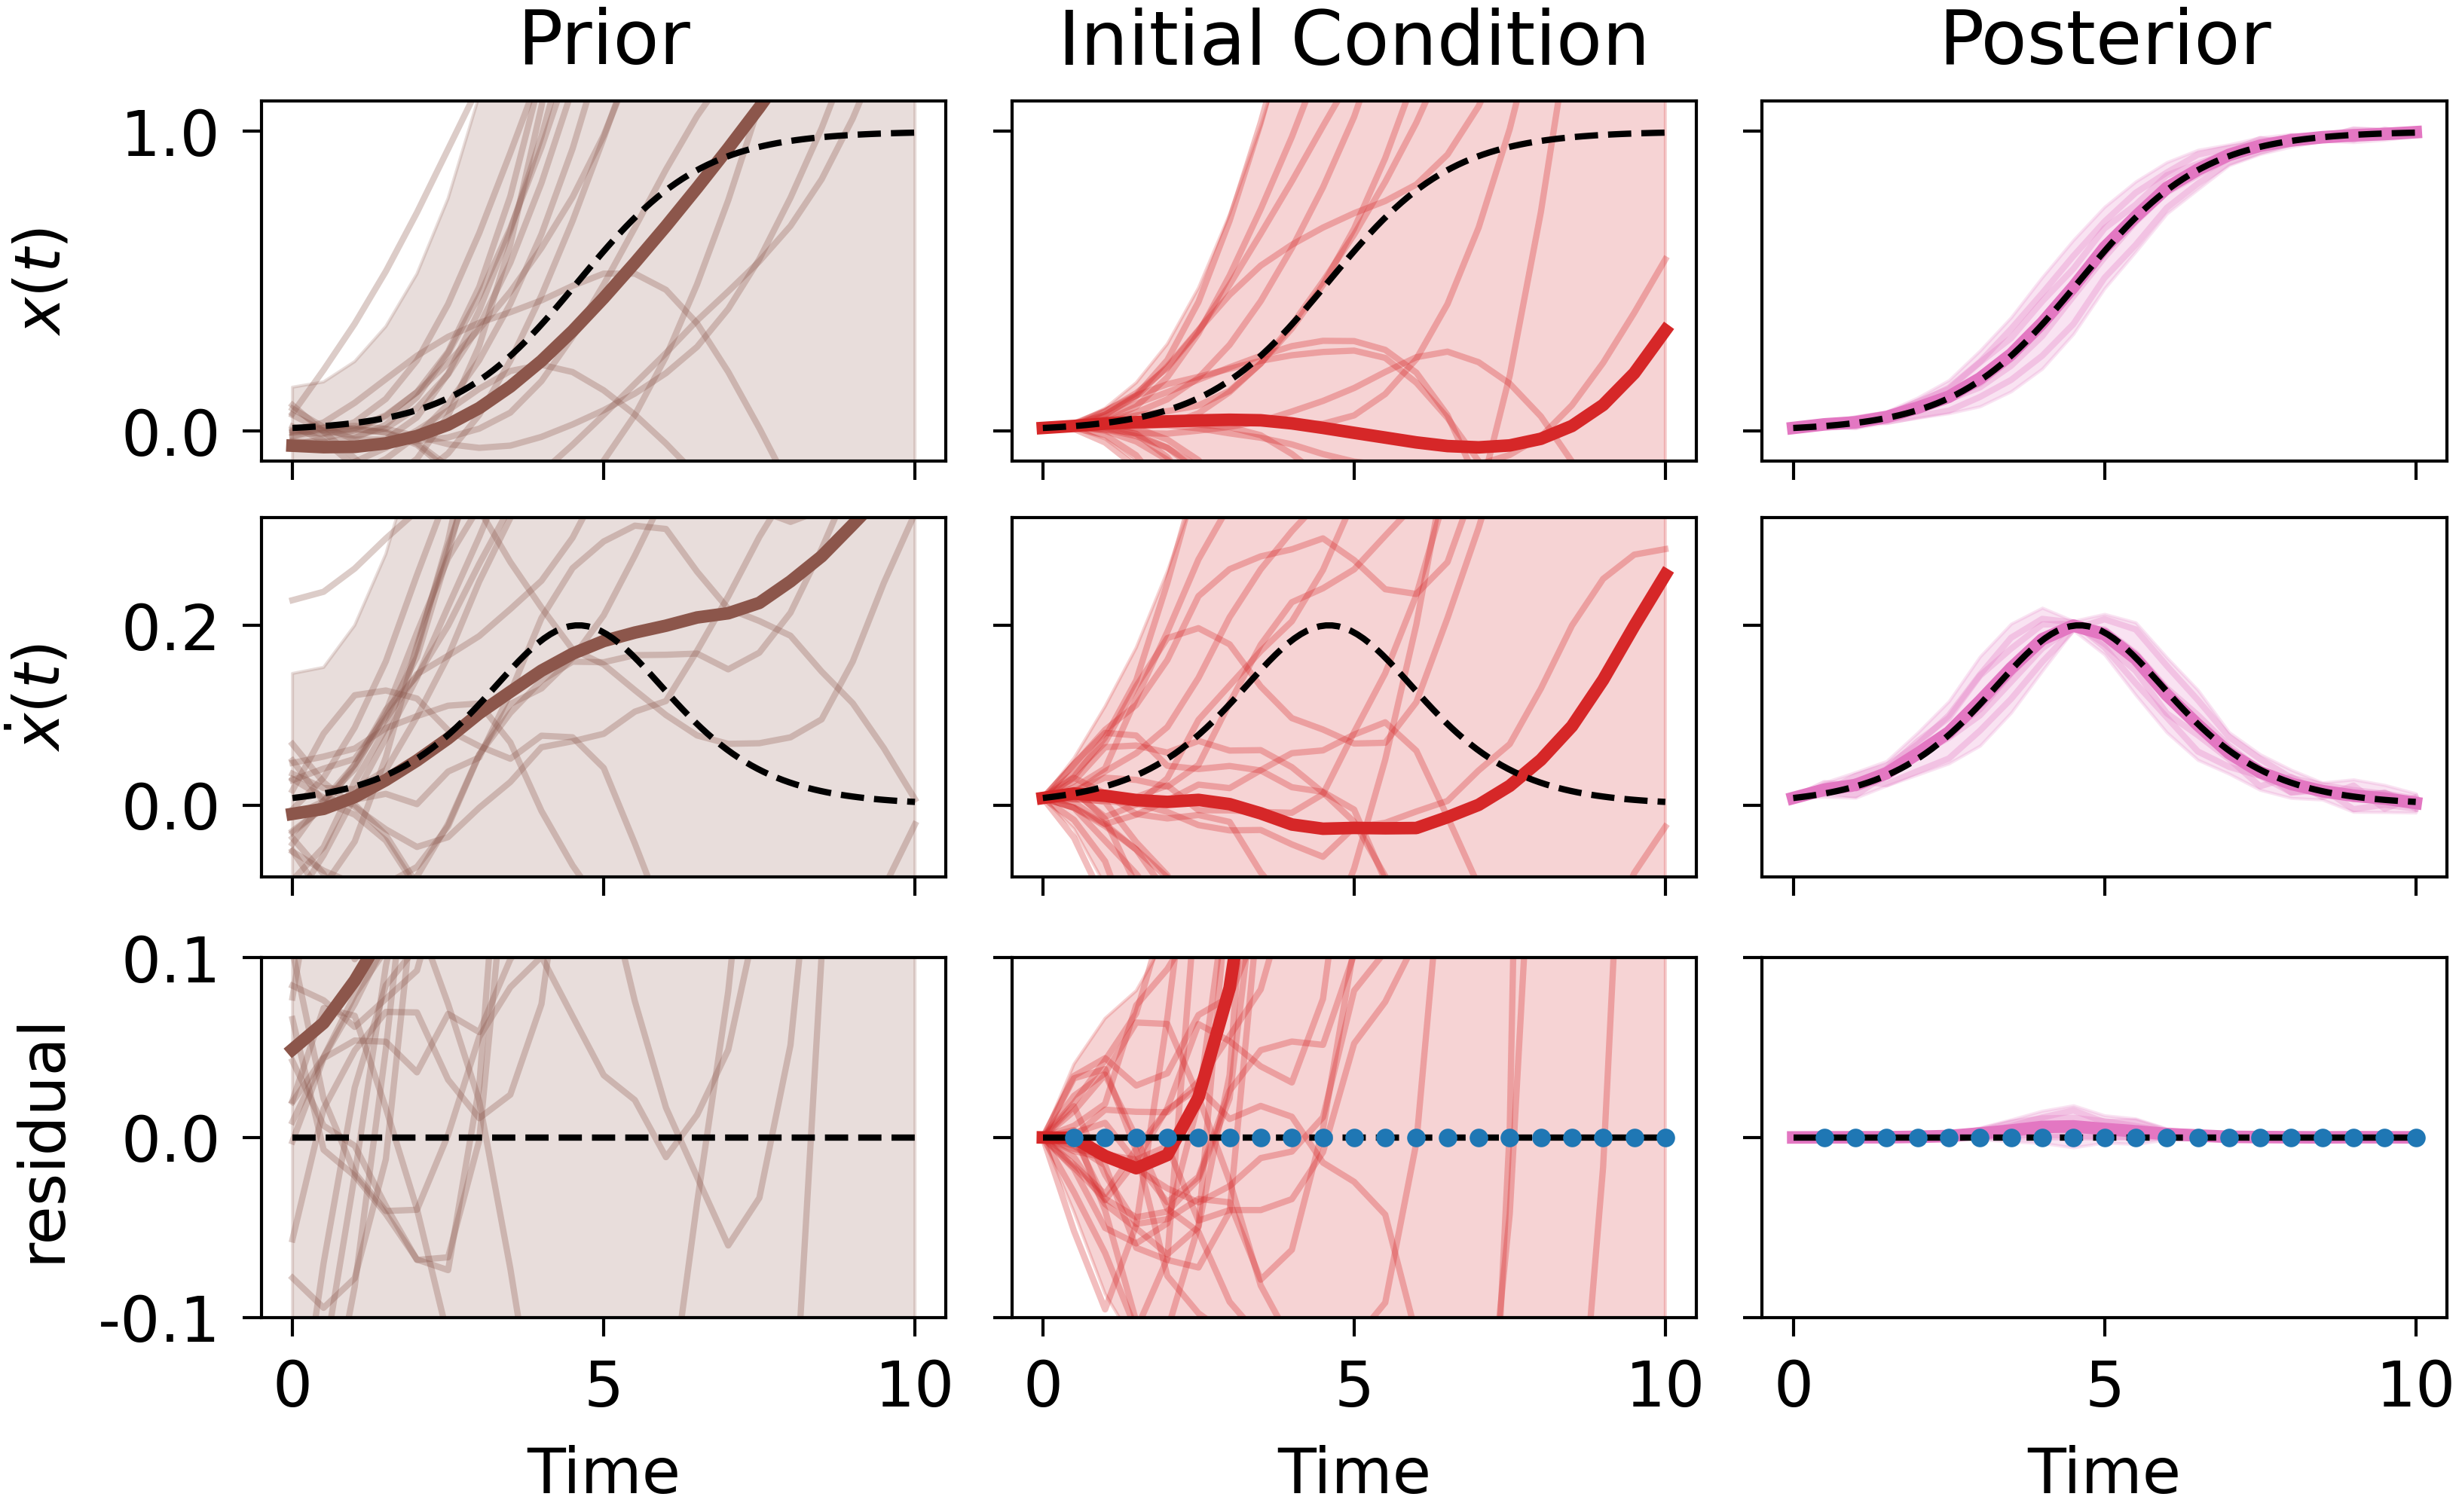

In [ ]:
# Create 3x3 subplot comparison: Prior, Initial Condition, Posterior
fig, axs = plt.subplots(3, 3, sharex=True)

# Configuration for each comparison type
sample_data = [
    (x_samples_IWP, colors[5], "Prior"),                    # Column 0
    (x_samples_IWP_taylor, colors[3], "Initial Condition"), # Column 1  
    (X_s_samples, colors[6], "Posterior")                   # Column 2
]

# Y-axis limits and labels for each row
y_limits = [[-0.1, 1.1], [-0.1, 0.4], [-0.1, 0.1]]
row_labels = [r'$x(t)$', r'$\dot{x}(t)$', 'residual']

# Plot all sample types
for col, (samples, sample_color, title) in enumerate(sample_data):
    # Set column title
    axs[0, col].set_title(title)
    
    # Plot exact solutions (ground truth)
    axs[0, col].plot(t, exact_sols[0](t), linestyle='--', color='black', zorder=10)
    axs[1, col].plot(t, exact_sols[1](t), linestyle='--', color='black', zorder=10)
    axs[2, col].plot(t, np.zeros_like(t), linestyle='--', color='black', zorder=10)
    
    # Compute statistics from samples
    sample_means = np.mean(samples, axis=0)  # Mean across samples
    sample_stds = np.std(samples, axis=0)    # Std deviation across samples
    
    # Plot sample paths (with reduced alpha for better visibility of mean/CI)
    for s in range(samples.shape[0]):
        # First two state components
        for row in range(2):
            axs[row, col].plot(ts, samples[s, :, row], alpha=0.3, color=sample_color)
        
        # Residual (bottom row) - compute based on sample type
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        axs[2, col].plot(ts, residual, alpha=0.3, color=sample_color)
    
    # Plot mean and confidence intervals for state components
    for row in range(2):
        # Plot mean
        axs[row, col].plot(ts, sample_means[:, row], color=sample_color, 
                          linewidth=2, label=f'{title} mean')
        
        # Plot 2-sigma confidence interval
        lower = sample_means[:, row] - 2 * sample_stds[:, row]
        upper = sample_means[:, row] + 2 * sample_stds[:, row]
        axs[row, col].fill_between(ts, lower, upper, alpha=0.2, color=sample_color)
    
    # Compute residual statistics
    residuals = []
    for s in range(samples.shape[0]):
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        residuals.append(residual)
    
    residuals = np.array(residuals)
    residual_mean = np.mean(residuals, axis=0)
    residual_std = np.std(residuals, axis=0)
    
    # Plot residual mean and confidence interval
    axs[2, col].plot(ts, residual_mean, color=sample_color, linewidth=2)
    lower_res = residual_mean - 2 * residual_std
    upper_res = residual_mean + 2 * residual_std
    axs[2, col].fill_between(ts, lower_res, upper_res, alpha=0.2, color=sample_color)
    
    # Add observed data for Initial Condition and Posterior columns
    if col > 0:
        axs[2, col].scatter(ts[1:], z_sequence, label="observed data", 
                           s=6, color=colors[5], zorder=10)
    
    # Set y-axis limits and remove tick labels for non-leftmost columns
    for row in range(3):
        axs[row, col].set_ylim(y_limits[row])
        if col > 0:
            axs[row, col].set_yticklabels([])

# Set labels and formatting for leftmost column only
for row in range(3):
    axs[row, 0].set_ylabel(row_labels[row])
    axs[row, 0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Set x-axis labels for bottom row
for col in range(3):
    axs[2, col].set_xlabel('Time')

fig.align_ylabels(axs)
plt.show()

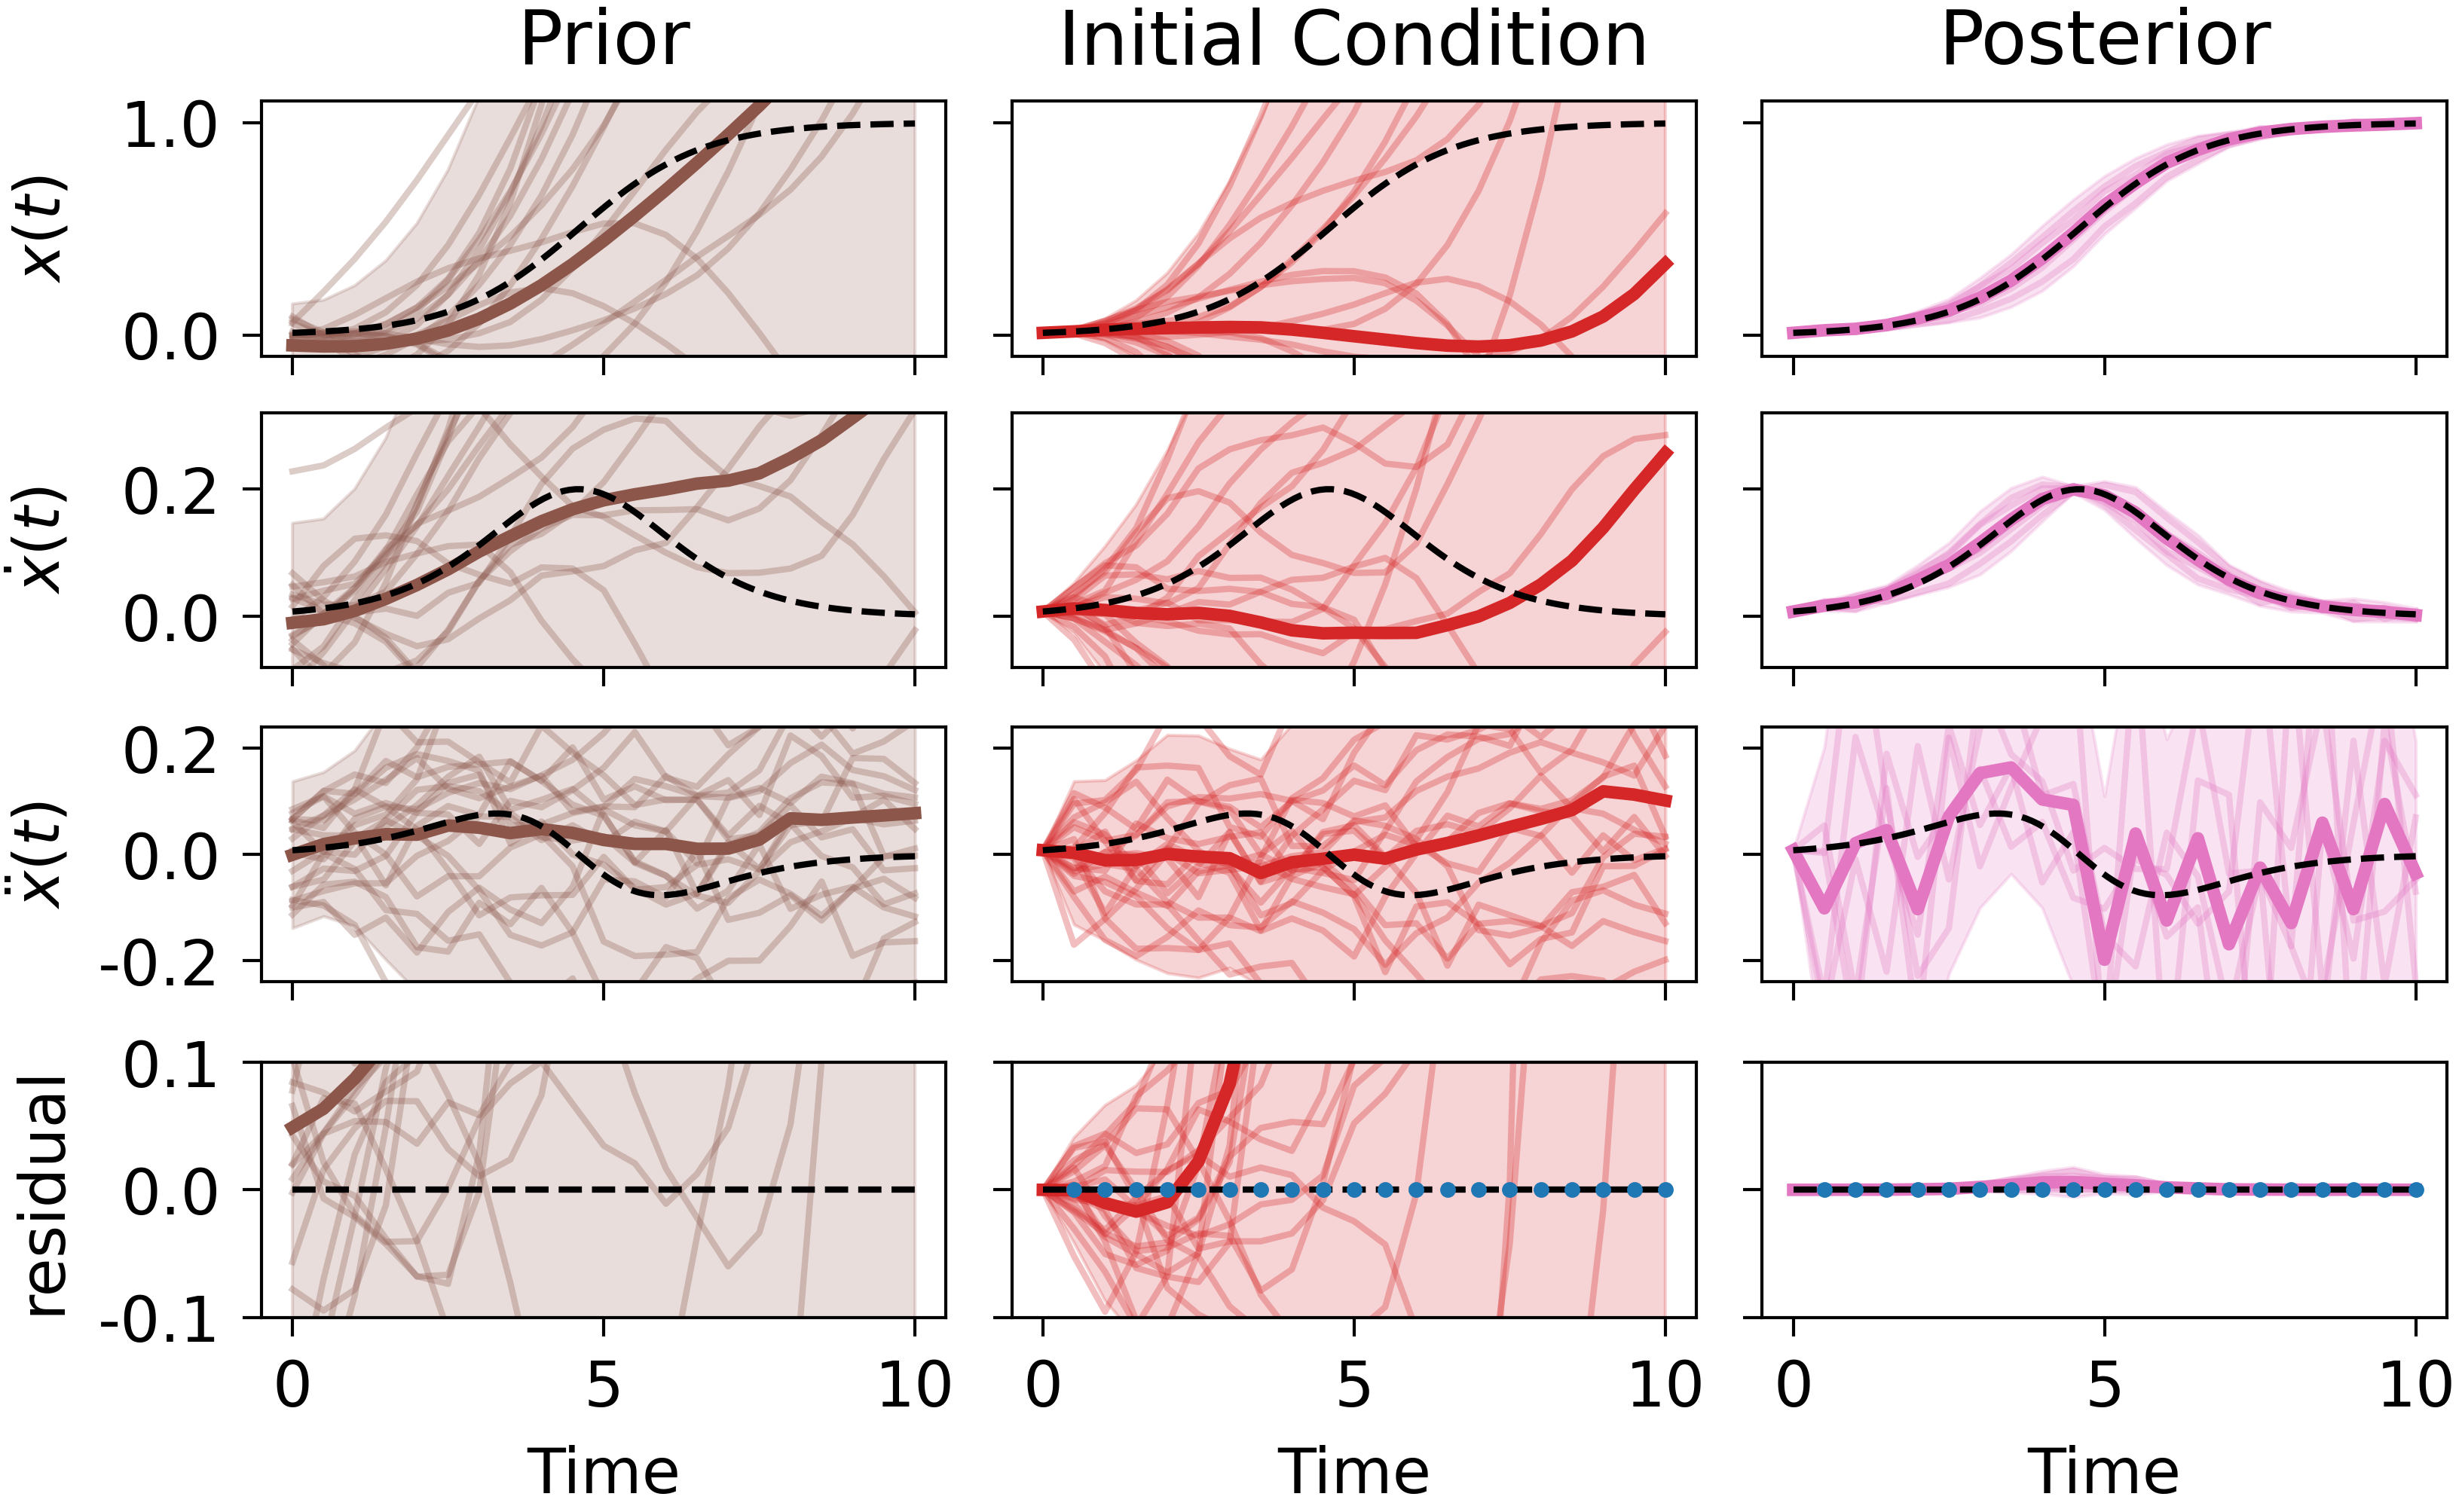

In [ ]:
# Create 4x3 subplot comparison: Prior, Initial Condition, Posterior
fig, axs = plt.subplots(4, 3, sharex=True)

# Configuration for each comparison type
sample_data = [
    (x_samples_IWP, colors[5], "Prior"),           # Column 0
    (x_samples_IWP_taylor, colors[3], "Initial Condition"),  # Column 1  
    (X_s_samples, colors[6], "Posterior")         # Column 2
]

# Y-axis limits for each row
y_limits = [[-0.1, 1.1], [-0.1, 0.4], [-0.3, 0.3], [-0.1, 0.1]]
row_labels = [r'$x(t)$', r'$\dot{x}(t)$', r'$\ddot{x}(t)$', 'residual']

# Plot all sample types
for col, (samples, sample_color, title) in enumerate(sample_data):
    # Set column title
    axs[0, col].set_title(title)
    
    # Plot exact solutions (ground truth) for all rows
    for row in range(3):
        axs[row, col].plot(t, exact_sols[row](t), linestyle='--', color='black', zorder=10)
    axs[3, col].plot(t, np.zeros_like(t), linestyle='--', color='black', zorder=10)
    
    # Compute statistics from samples
    sample_means = np.mean(samples, axis=0)  # Mean across samples
    sample_stds = np.std(samples, axis=0)    # Std deviation across samples
    
    # Plot sample paths (with reduced alpha for better visibility of mean/CI)
    for s in range(samples.shape[0]):
        # State components (rows 0-2)
        for row in range(3):
            axs[row, col].plot(ts, samples[s, :, row], alpha=0.3, color=sample_color)
        
        # Residual (row 3) - compute based on sample type
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        axs[3, col].plot(ts, residual, alpha=0.3, color=sample_color)
    
    # Plot mean and confidence intervals
    for row in range(3):
        # Plot mean
        axs[row, col].plot(ts, sample_means[:, row], color=sample_color, 
                          linewidth=2, label=f'{title} mean')
        
        # Plot 2-sigma confidence interval
        lower = sample_means[:, row] - 2 * sample_stds[:, row]
        upper = sample_means[:, row] + 2 * sample_stds[:, row]
        axs[row, col].fill_between(ts, lower, upper, alpha=0.2, color=sample_color)
    
    # Compute residual statistics
    residuals = []
    for s in range(samples.shape[0]):
        if col == 2:  # Posterior samples
            residual = samples[s, :, 1] - samples[s, :, 0] * (1 - samples[s, :, 0])
        else:  # Prior and Initial Condition samples
            residual = samples[s, :, 1] - vf(samples[s, :, 0])
        residuals.append(residual)
    
    residuals = np.array(residuals)
    residual_mean = np.mean(residuals, axis=0)
    residual_std = np.std(residuals, axis=0)
    
    # Plot residual mean and confidence interval
    axs[3, col].plot(ts, residual_mean, color=sample_color, linewidth=2)
    lower_res = residual_mean - 2 * residual_std
    upper_res = residual_mean + 2 * residual_std
    axs[3, col].fill_between(ts, lower_res, upper_res, alpha=0.2, color=sample_color)
    
    # Add observed data for Initial Condition and Posterior columns
    if col > 0:
        axs[3, col].scatter(ts[1:], z_sequence, label="observed data", 
                           s=4, color=colors[5], zorder=11)
    
    # Set y-axis limits and formatting
    for row in range(4):
        axs[row, col].set_ylim(y_limits[row])
        if col > 0:  # Remove y-tick labels for columns 1 and 2
            axs[row, col].set_yticklabels([])

# Set labels and formatting for leftmost column only
for row in range(4):
    axs[row, 0].set_ylabel(row_labels[row])
    axs[row, 0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Set x-axis labels for bottom row
for col in range(3):
    axs[3, col].set_xlabel('Time')

fig.align_ylabels(axs)
plt.show()
